In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from scipy.linalg import sqrtm
from statsmodels.stats.correlation_tools import cov_nearest
from torchdiffeq import odeint

from ml import KramersMoyal, load_kernels_dict
from neural_ode import ODEfunc, RunningAverageMeter
from plot import ImperialColors, plot_simulation
from potenciala import BucketMethod, VectorTimeSeries
from stochastic import (EulerMaruyama, SpatialNearestDriftMultivariate, ConstantDiffusionMultivariate)

In [3]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [4]:
df = df_raw.query("year >= 2004 & year <= 2020")

### Load VectorTimeSeries and drift and diffusion coefficients

In [5]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)
expected_drift_kde_df = KramersMoyal.obtain_first_coefficient_vector(kernels_dict=d_1_dict)

d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)
second_km_kde_matrix = KramersMoyal.obtain_second_coefficient_matrix(diag_kernels_dict=d_2_diag_dict, 
                                                                     non_diag_kernels_dict=d_2_non_diag_dict)

drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

sqrt_diff_matrix_kde = sqrtm(cov_nearest(cov=2*second_km_kde_matrix, threshold=1e-14))
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

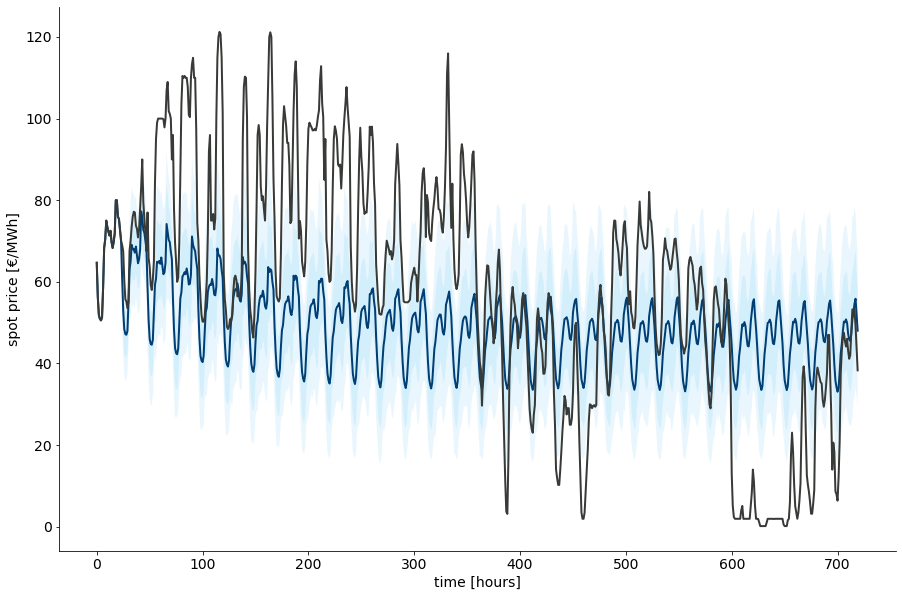

In [6]:
sim_periods = 30
x_df = df_raw[df_raw["date"] >= "2021-01-05"].iloc[:24*sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=1_000, periods=sim_periods, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=1024)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

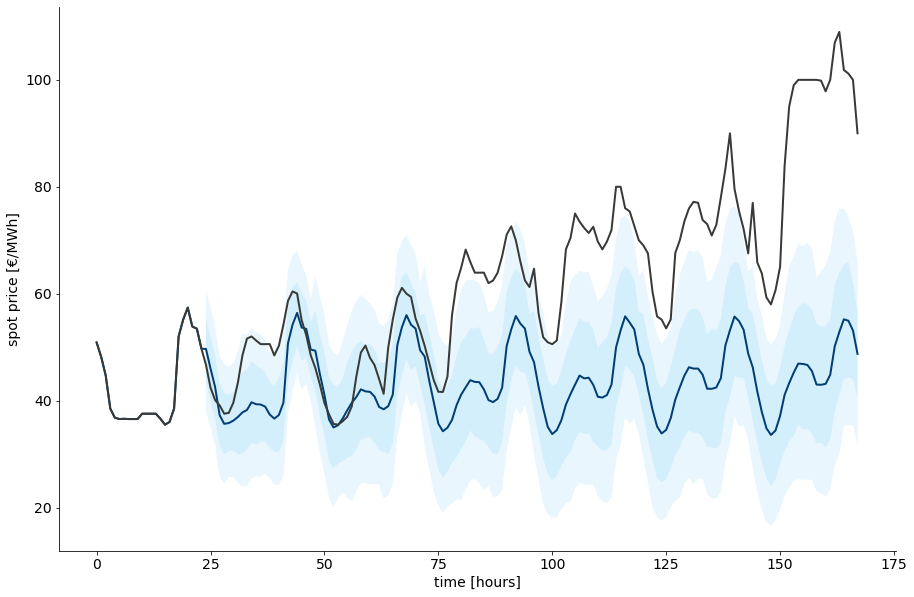

In [7]:
sim_periods = 7
x_df = df_raw[df_raw["date"] >= "2021-01-01"].iloc[:24*sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=1_000, periods=sim_periods, delta_t=1, nu=0, drift=drift_kde, diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=1024)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

### Compute difference between simulation and external drift to generate training set

In [8]:
diff_df = sim_df.subtract(x_df_kde.reset_index()["spain"], axis="index")
diff_df.index = pd.RangeIndex(start=1, stop=diff_df.index.max()+2, step=1)

hour_indexes = np.vstack([np.arange(1, 25, 1) + 24*i for i in range(sim_periods)]).T

In [9]:
hours_list = np.arange(1, 25)
ts = np.arange(0, sim_periods)
multi_idx = pd.MultiIndex.from_product([hours_list, ts])
hour_ts_diff_df = pd.DataFrame(index=multi_idx, columns=diff_df.columns, dtype=np.float)

for i, h in enumerate(hours_list):
    hour_ts_diff_df.loc[h] = diff_df.loc[hour_indexes[i]].values

/var/folders/n4/4pcf4gm94bsfkqcmfpznj3nh0000gp/T/ipykernel_46367/227803648.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hour_ts_diff_df = pd.DataFrame(index=multi_idx, columns=diff_df.columns, dtype=np.float)


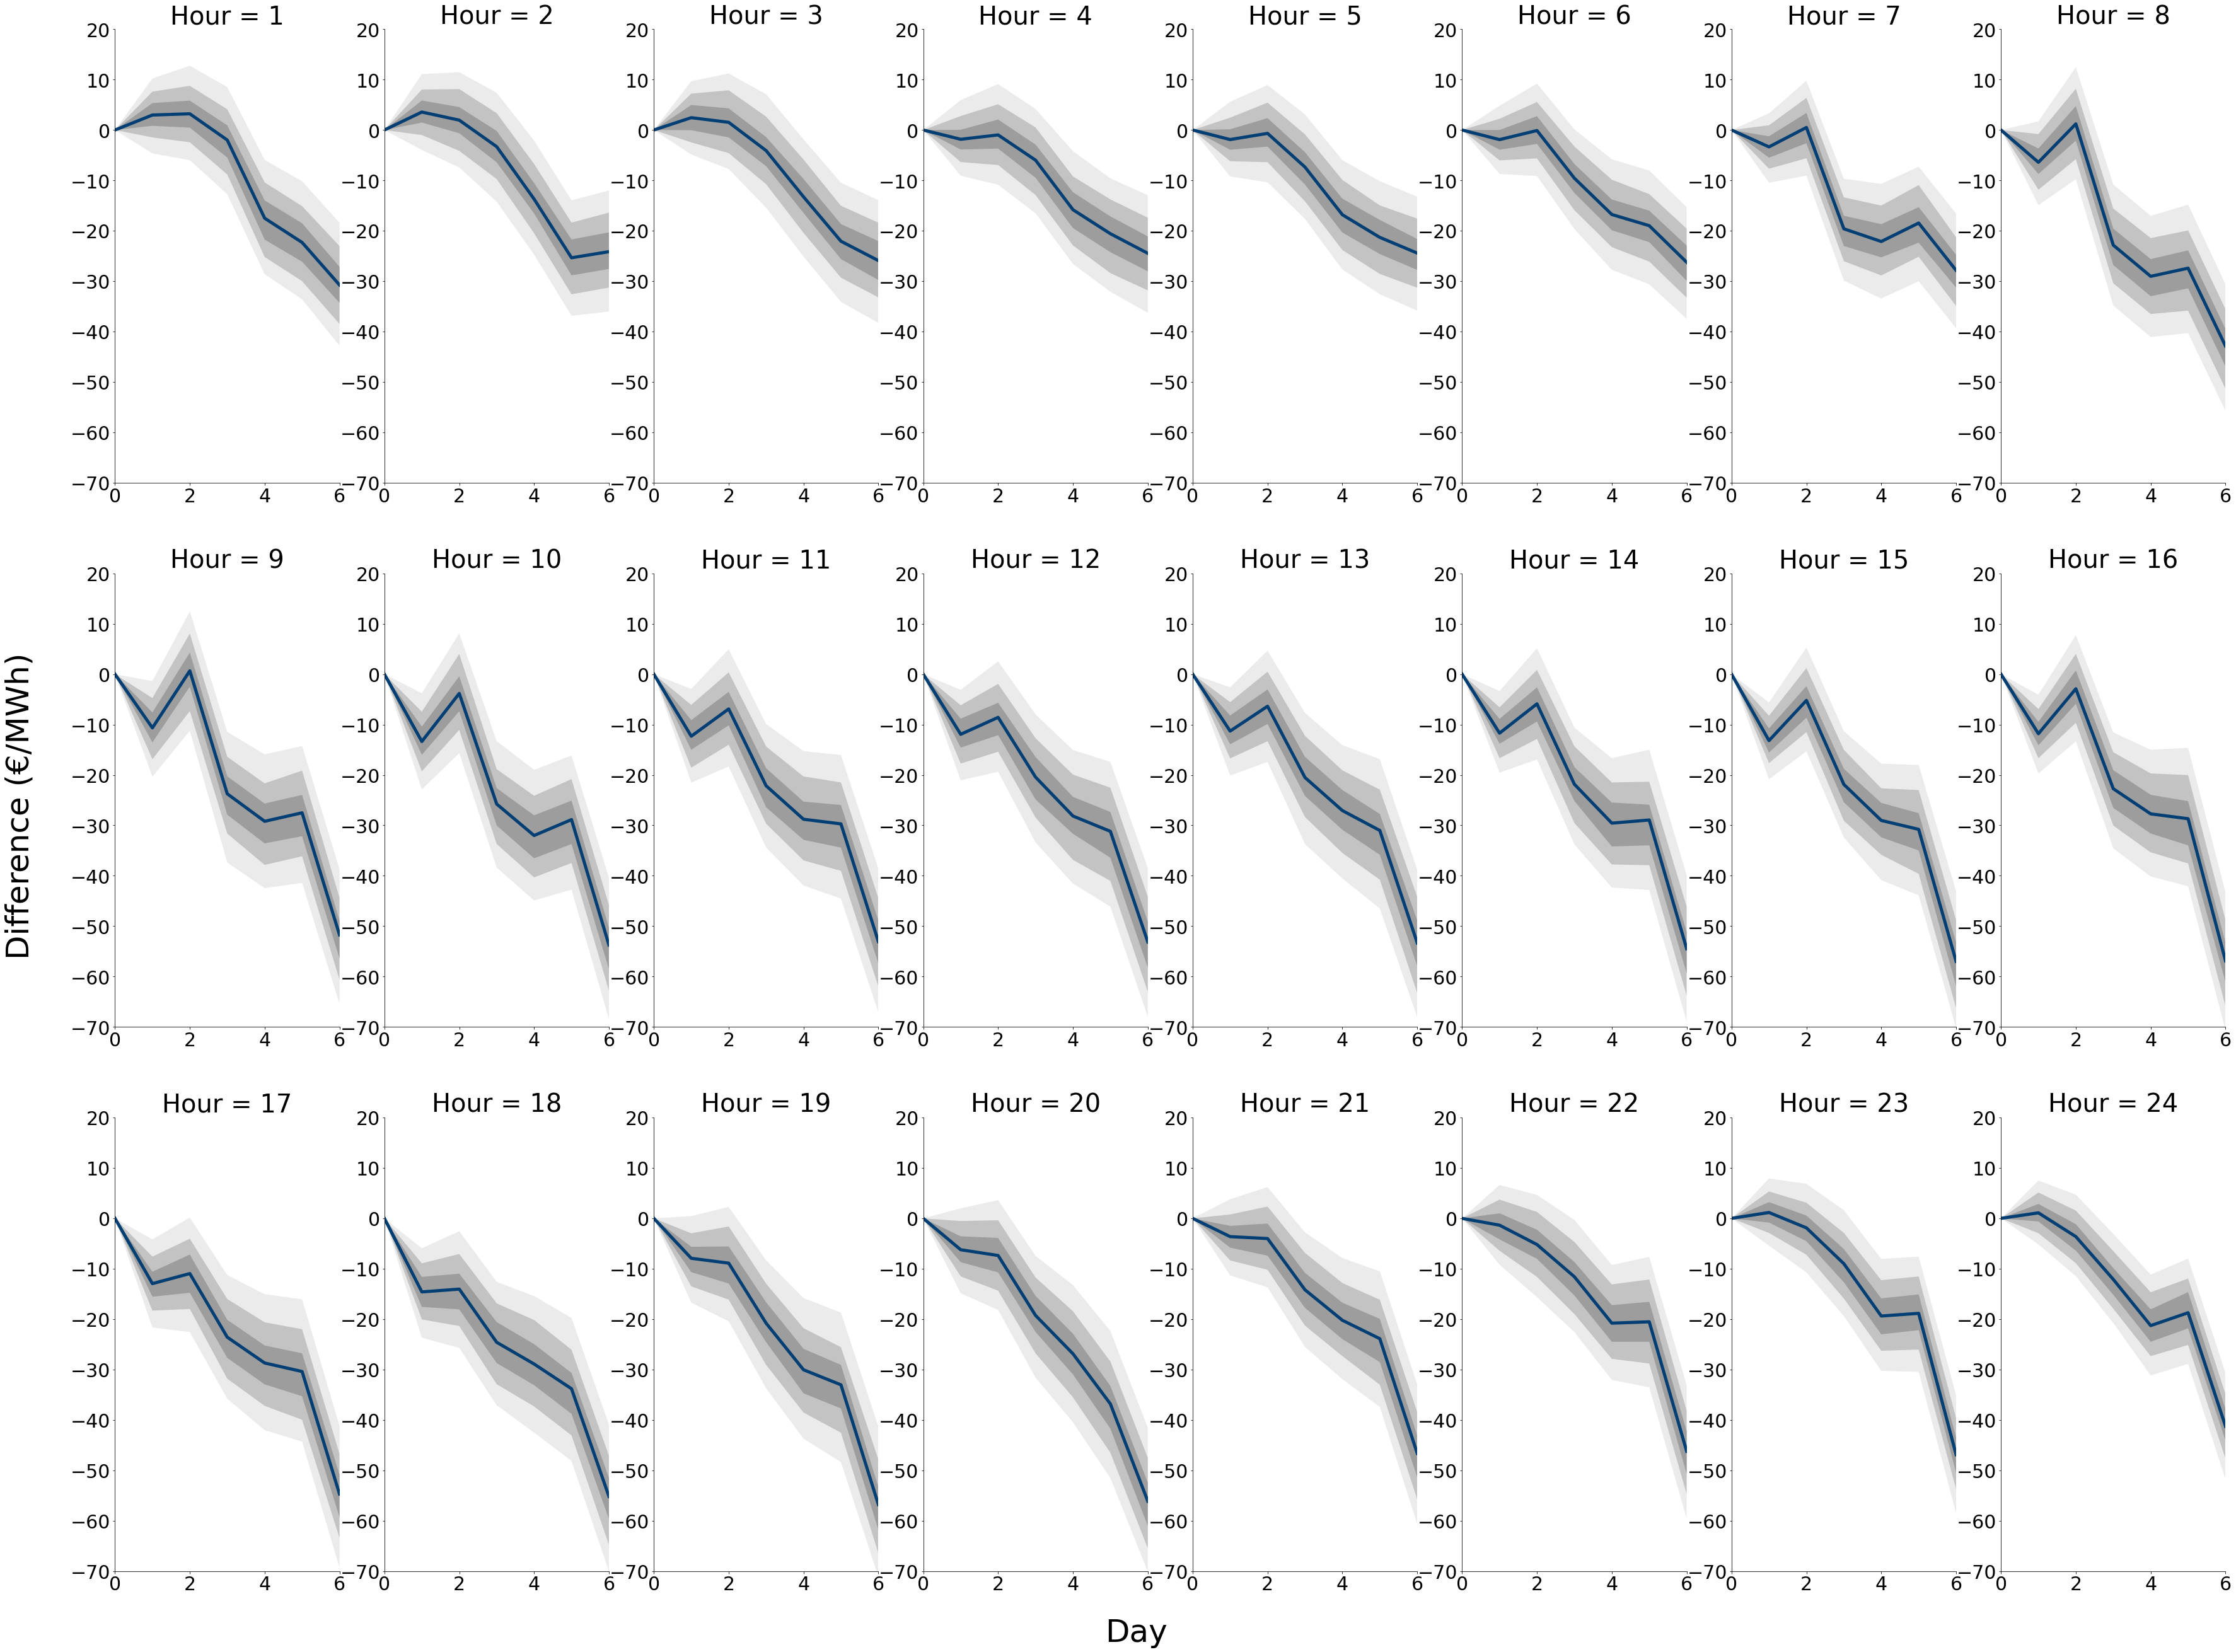

In [10]:
fig, axis = plt.subplots(3, 8, figsize=(60, 45))
percentiles_alpha = [0.2, 0.5, 1]
quantile = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        hour_ts_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        
        percentile_df = hour_ts_diff_df.loc[h].quantile(q=quantile, axis=1)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                percentile_df.columns, percentile_df.loc[quantile[k]], percentile_df.loc[quantile[-k-1]],
                facecolor=ImperialColors.cool_grey.value, alpha=alpha_value
            )
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, 6)
        ax.set_ylim(-70, 20)
        ax.tick_params(axis="both", labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)
plt.show()

### Train simple neural ODE to learn external drift

In [11]:
def get_multivariate_batch(train_df: pd.DataFrame, time_step: int):
    batch_y = np.zeros((time_step+1, 30, 1, 24)) # shape: (time, batch_size, 1, obs_dim)
    batch_t = torch.from_numpy(np.arange(time_step+1, dtype=np.float64))
    col_indexes = np.random.choice(train_df.columns, size=30, replace=False) # pick batch_size columns
    # iterate through each timestamp to get array of shape (batch_zise, 1, obs_dim)
    for h in range(time_step+1):
        batch_y[h] = train_df[col_indexes].xs(h, level=1, drop_level=False).T.values.reshape(30, 1, 24)
    batch_y0 = torch.from_numpy(batch_y[0]).float()
    batch_y = torch.from_numpy(batch_y)
        
    return batch_y0, batch_t, batch_y

def get_mean_tensor_from_trajectories(traj_df: pd.DataFrame, time_step: int):
    tensor_1d = traj_df.xs(time_step, level=1, drop_level=False).mean(axis=1).values
    tensor_1d = torch.from_numpy(tensor_1d.reshape(1, 1, -1)).float().to(device)
    
    return tensor_1d

def plot_training_evaluation(pred_tensor: torch.tensor, train_df: pd.DataFrame, training_ts: int):
    fig, axis = plt.subplots(3, 8, figsize=(60, 45))

    pred_df = pd.DataFrame(pred_tensor.reshape(-1, 24).T, index=np.arange(1, 25))
    
    for i, ax_list in enumerate(axis):
        for j, ax in enumerate(ax_list):
            h = 1 + i*8+j
            hour_ts_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
            pred_df.loc[h].plot(ax=ax, lw=5, color=ImperialColors.dark_green.value)
            ax.axvline(x=training_ts, color=ImperialColors.cool_grey.value)
    
            ax.set_xlabel("")
            ax.set_title(f"Hour = {h}", fontsize=40)
            ax.set_xlim(0, pred_df.shape[-1])
            ax.set_ylim(-70, 10)
            ax.tick_params(axis="both", labelsize=30)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
    fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
    fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)

Training time step 1 - Iteration: 0000 | Total loss 5.873914 | Time: 0.00 mins


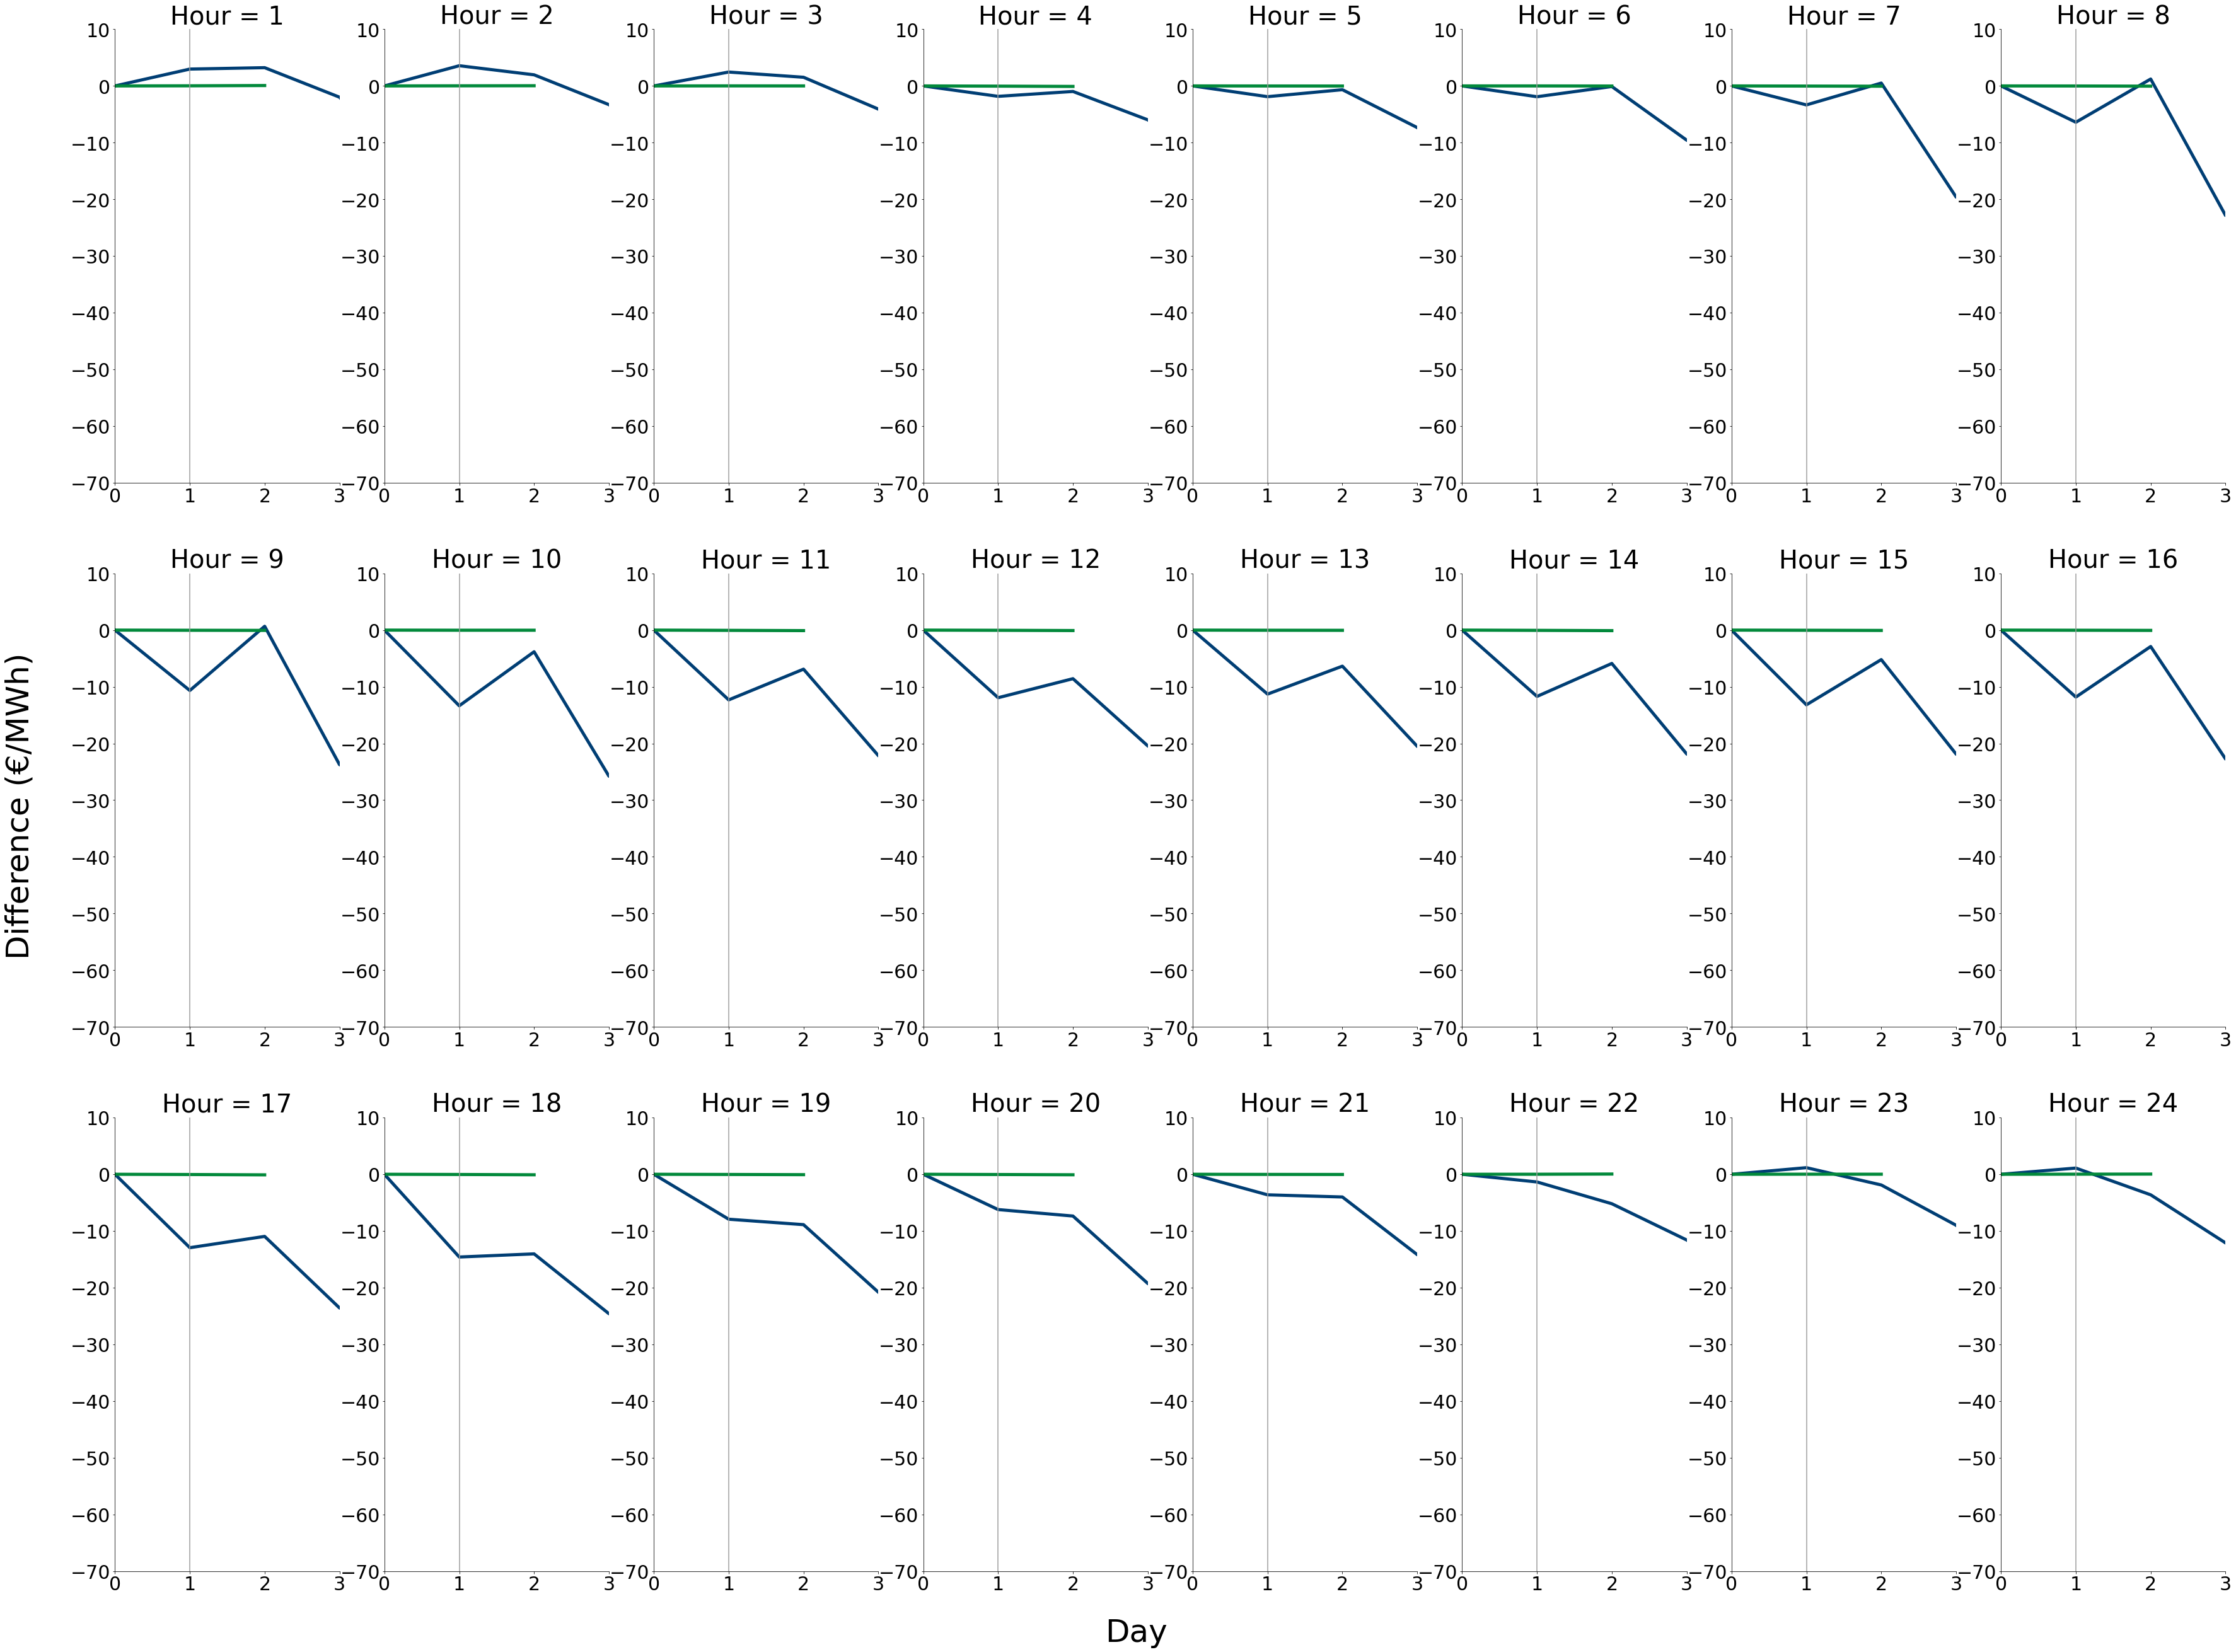

Mean absolute value error for test: 4.40


Training time step 1 - Iteration: 0250 | Total loss 3.775984 | Time: 0.30 mins
Training time step 1 - Iteration: 0500 | Total loss 3.782531 | Time: 0.56 mins
Training time step 1 - Iteration: 0750 | Total loss 3.761643 | Time: 0.82 mins
Training time step 1 - Iteration: 1000 | Total loss 3.784598 | Time: 1.09 mins


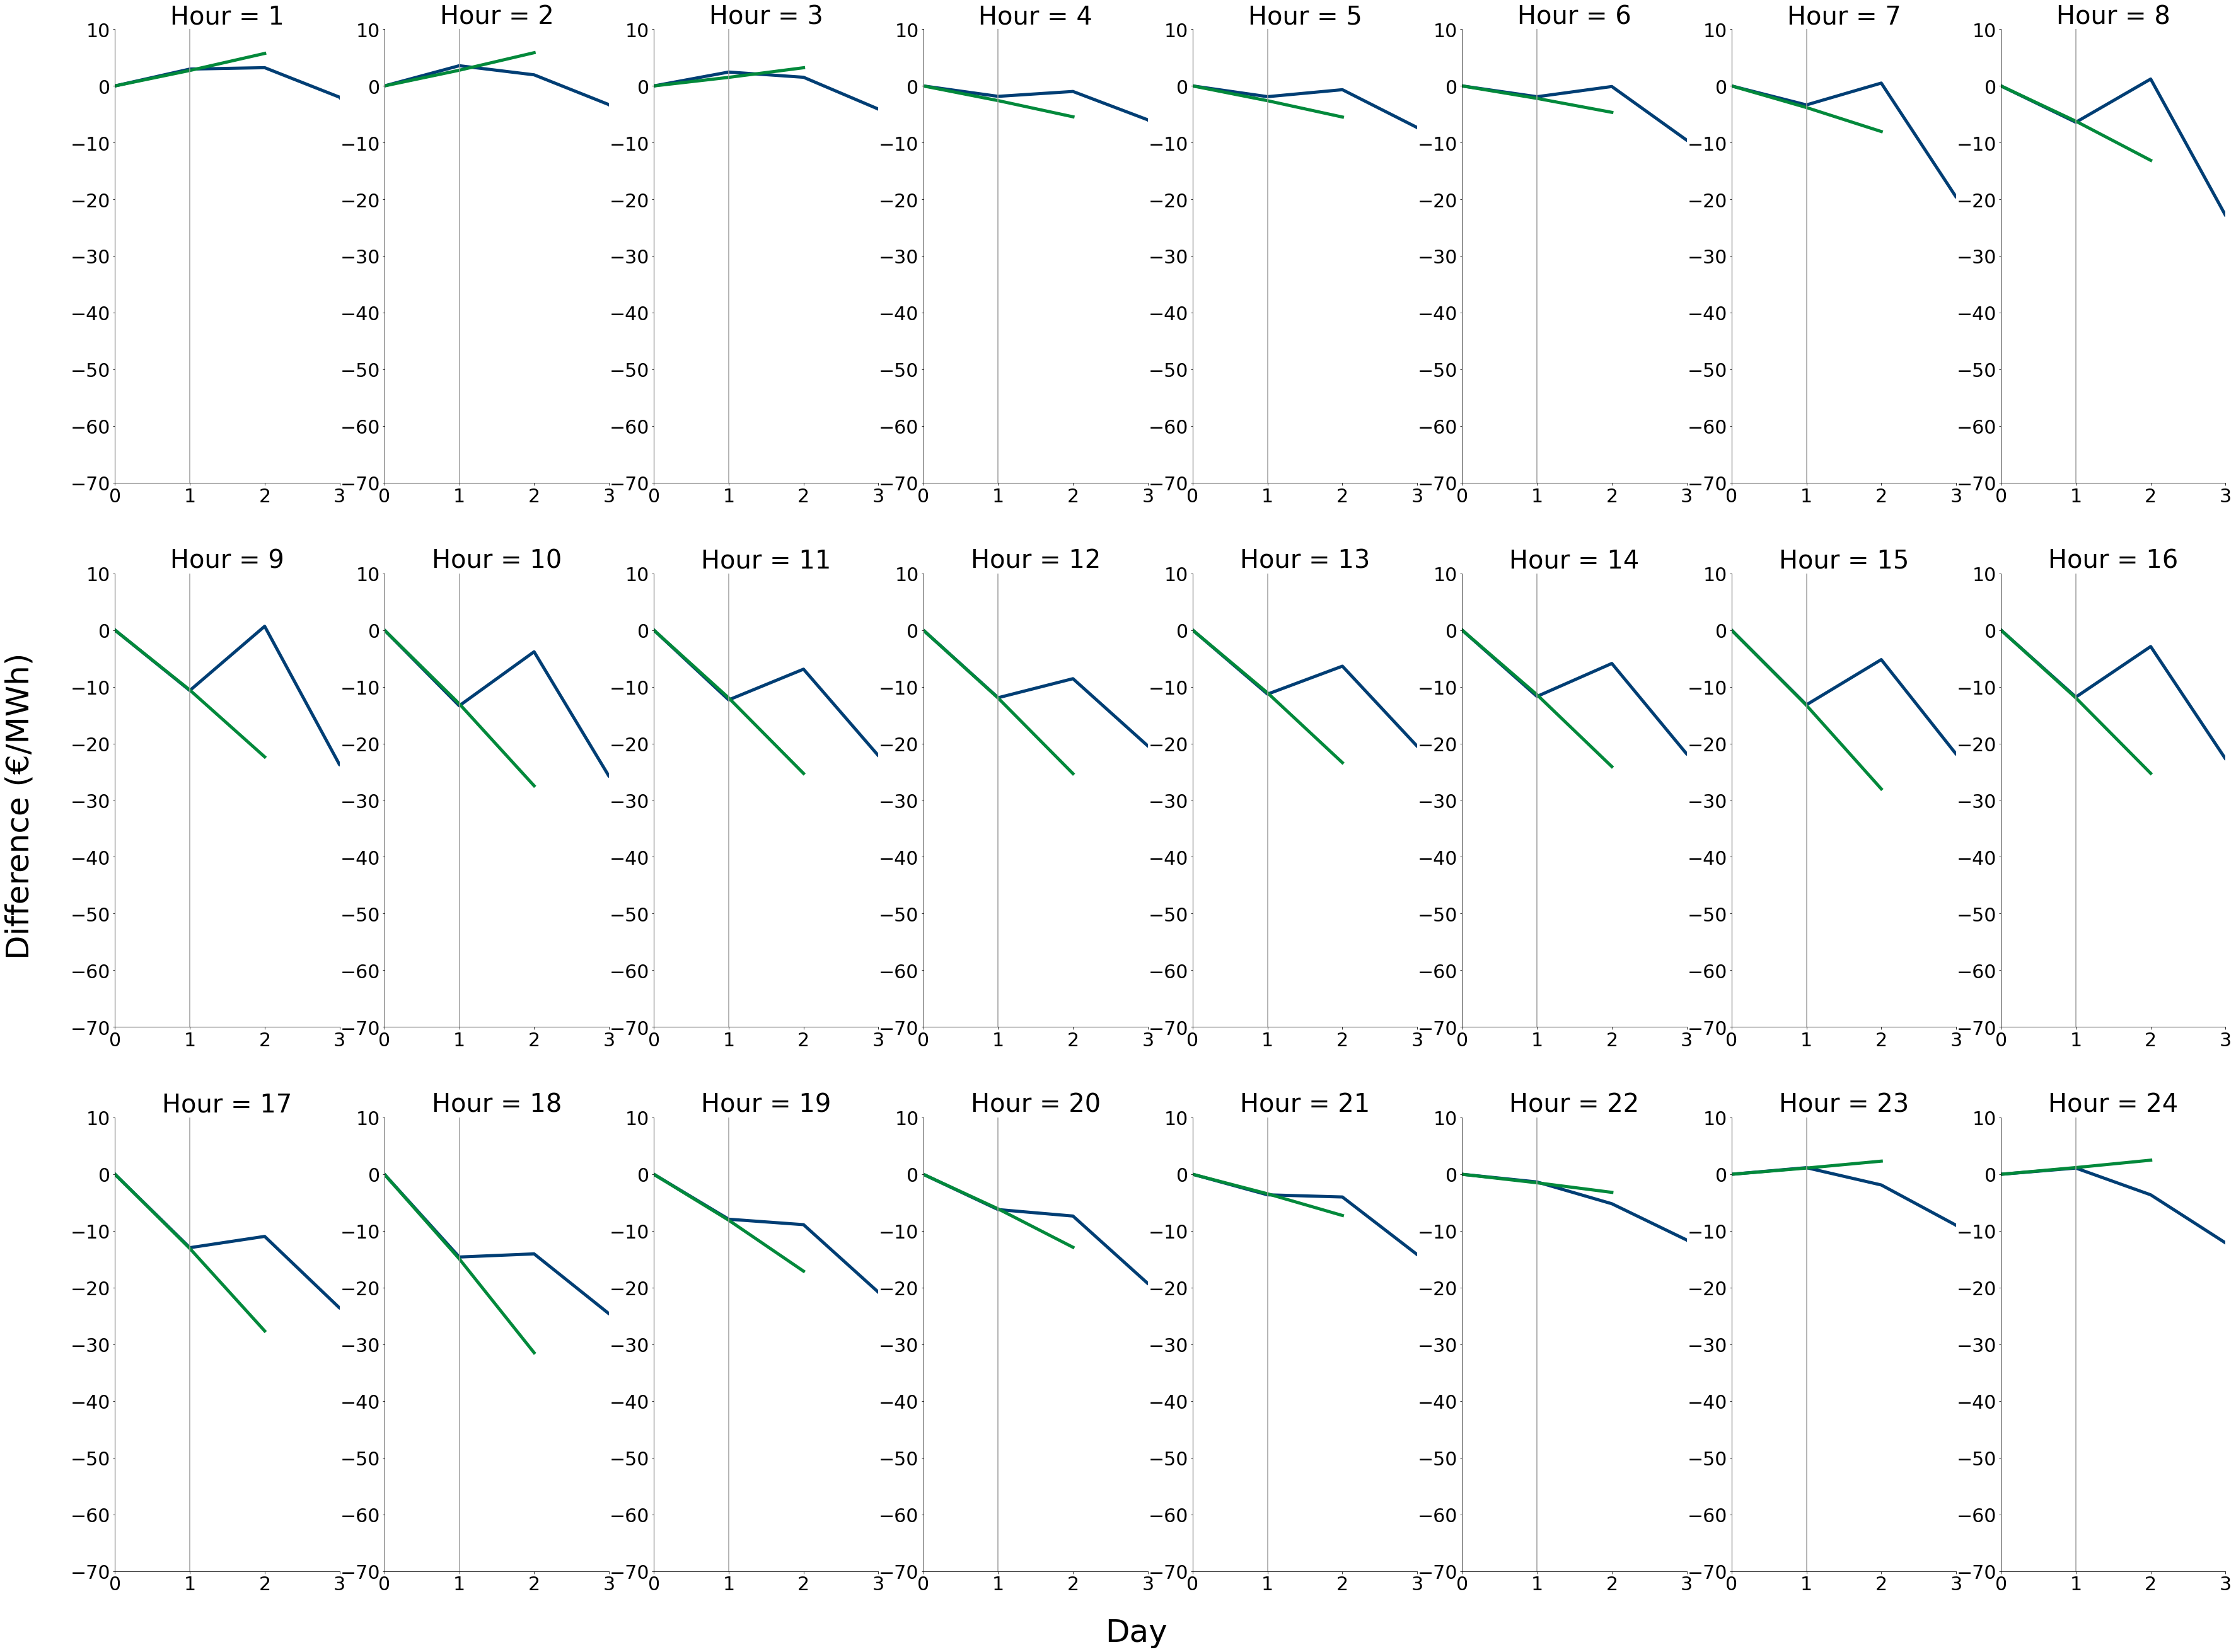

Mean absolute value error for test: 11.27


Training time step 1 - Iteration: 1250 | Total loss 3.819198 | Time: 1.38 mins
Training time step 1 - Iteration: 1500 | Total loss 3.775346 | Time: 1.64 mins
Training time step 1 - Iteration: 1750 | Total loss 3.784811 | Time: 1.90 mins
Training time step 1 - Iteration: 2000 | Total loss 3.783846 | Time: 2.16 mins


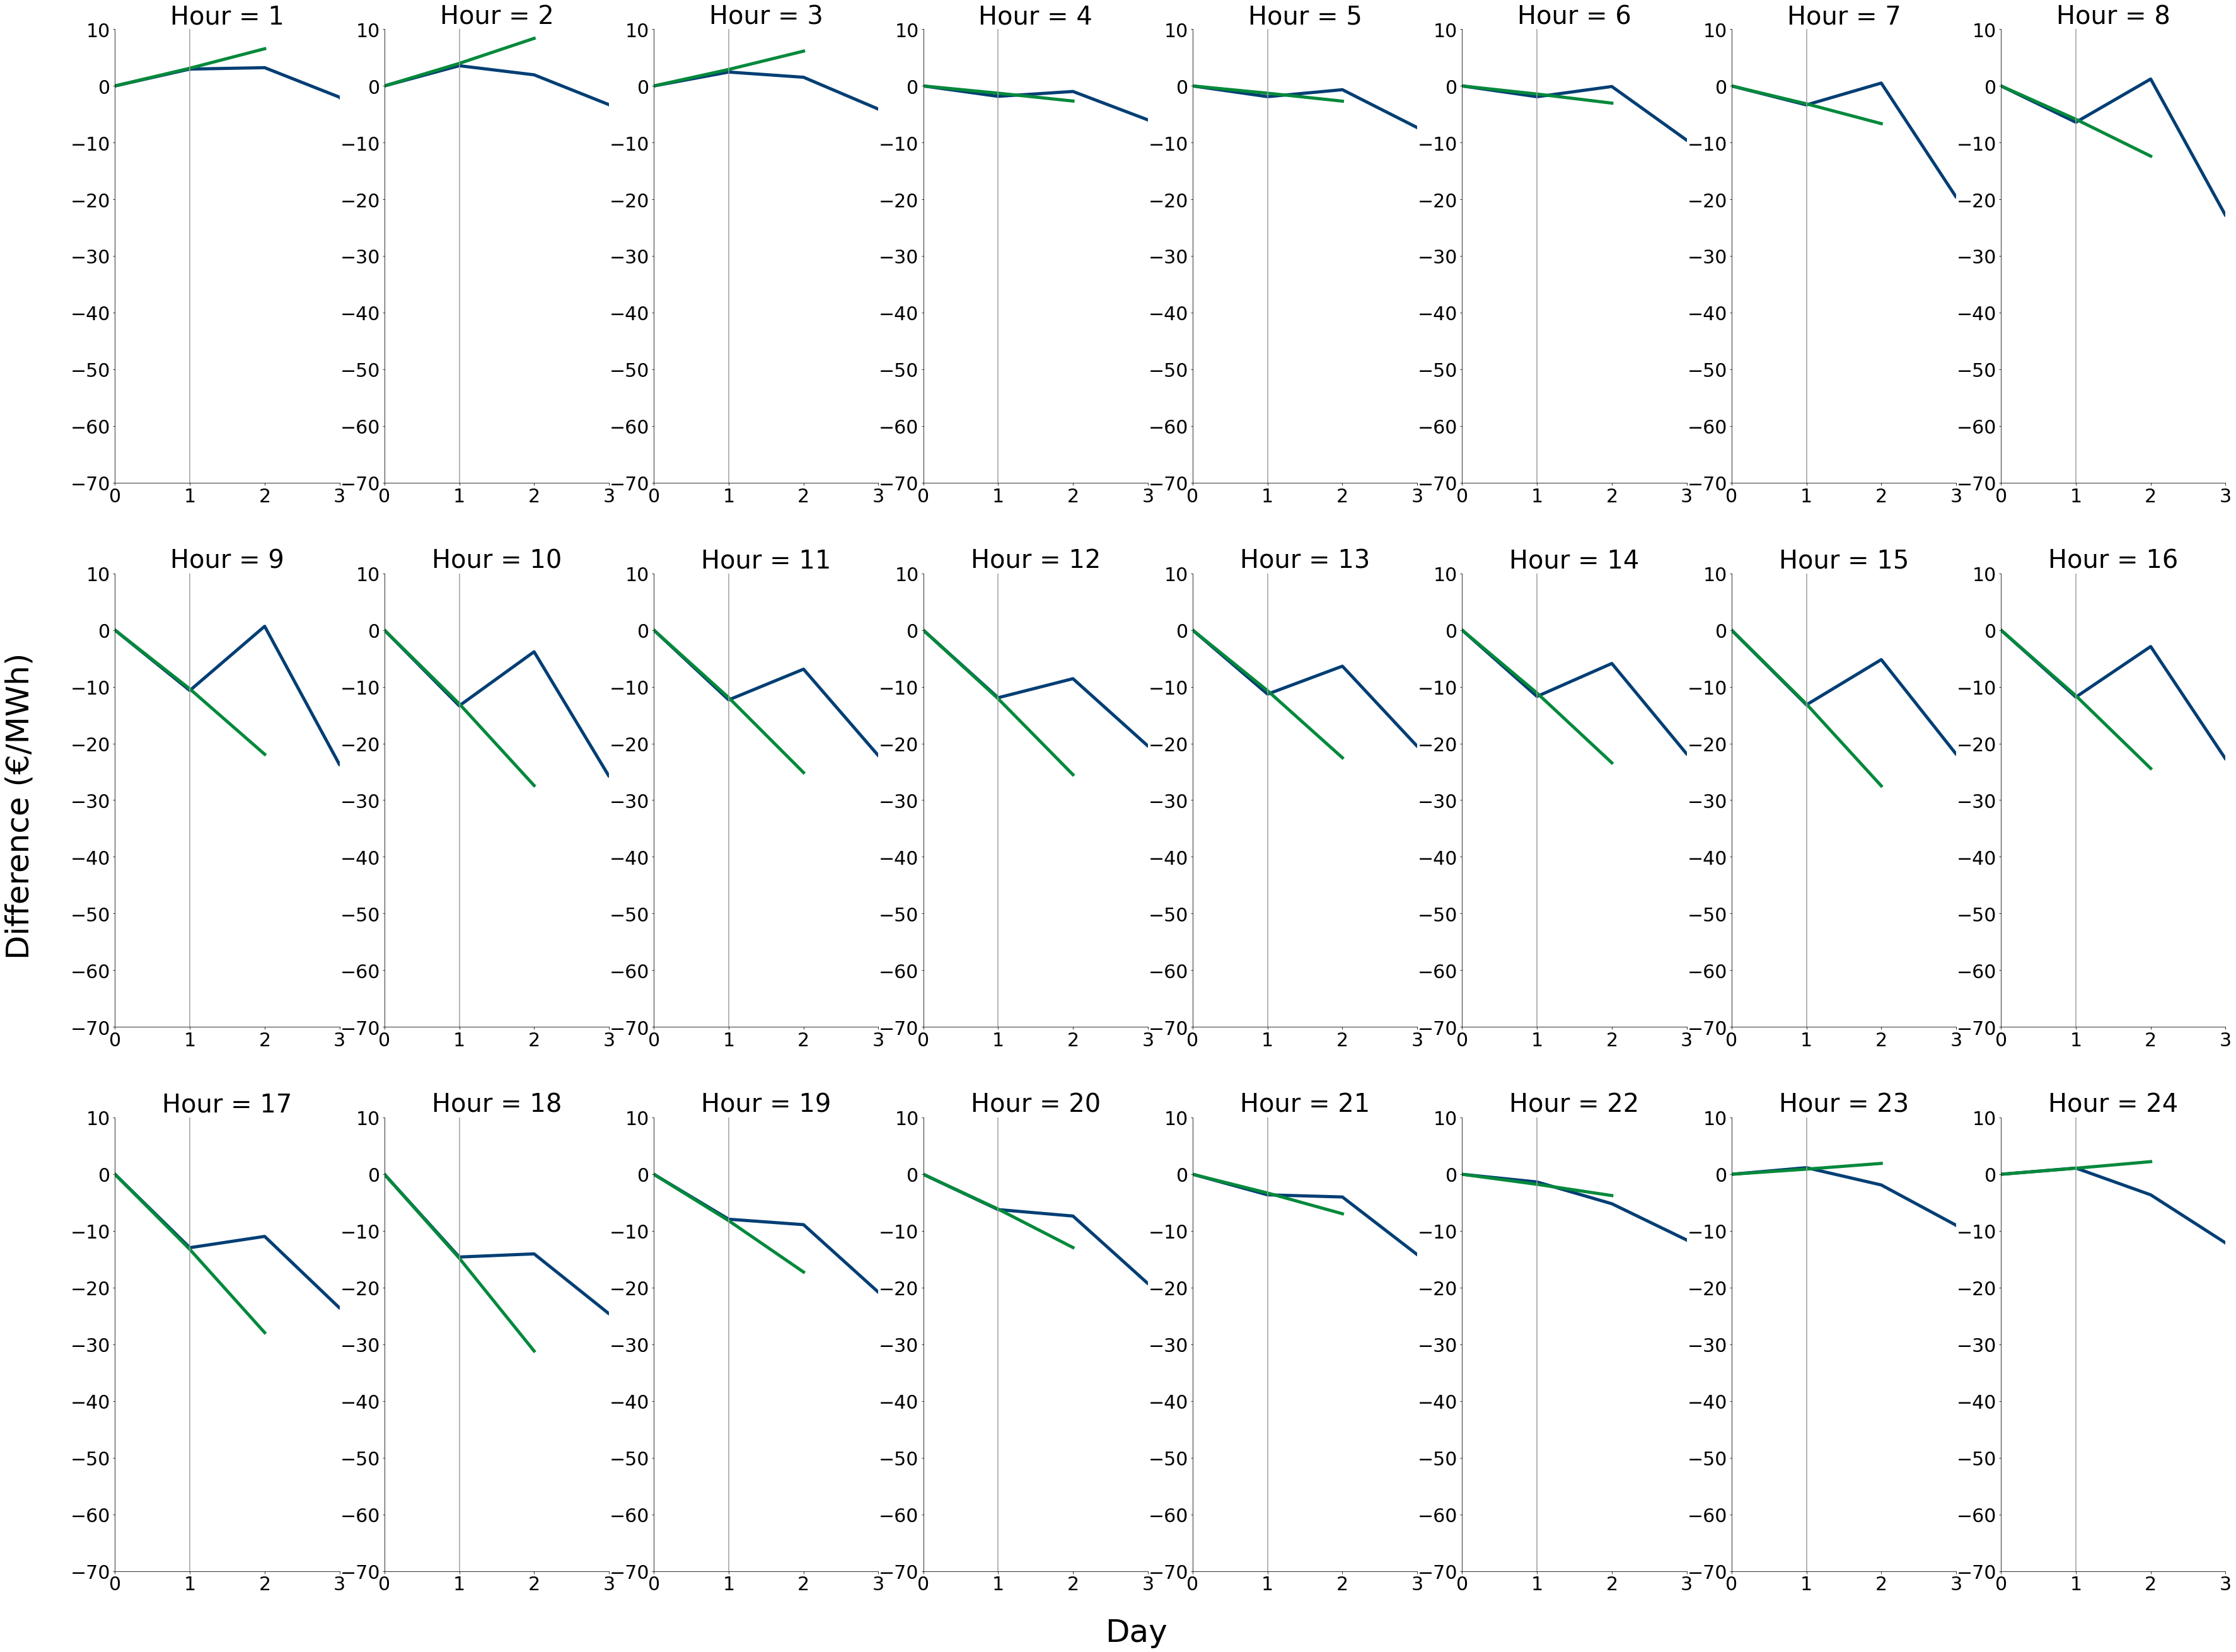

Mean absolute value error for test: 10.94


Training time step 2 - Iteration: 0000 | Total loss 7.530547 | Time: 2.19 mins


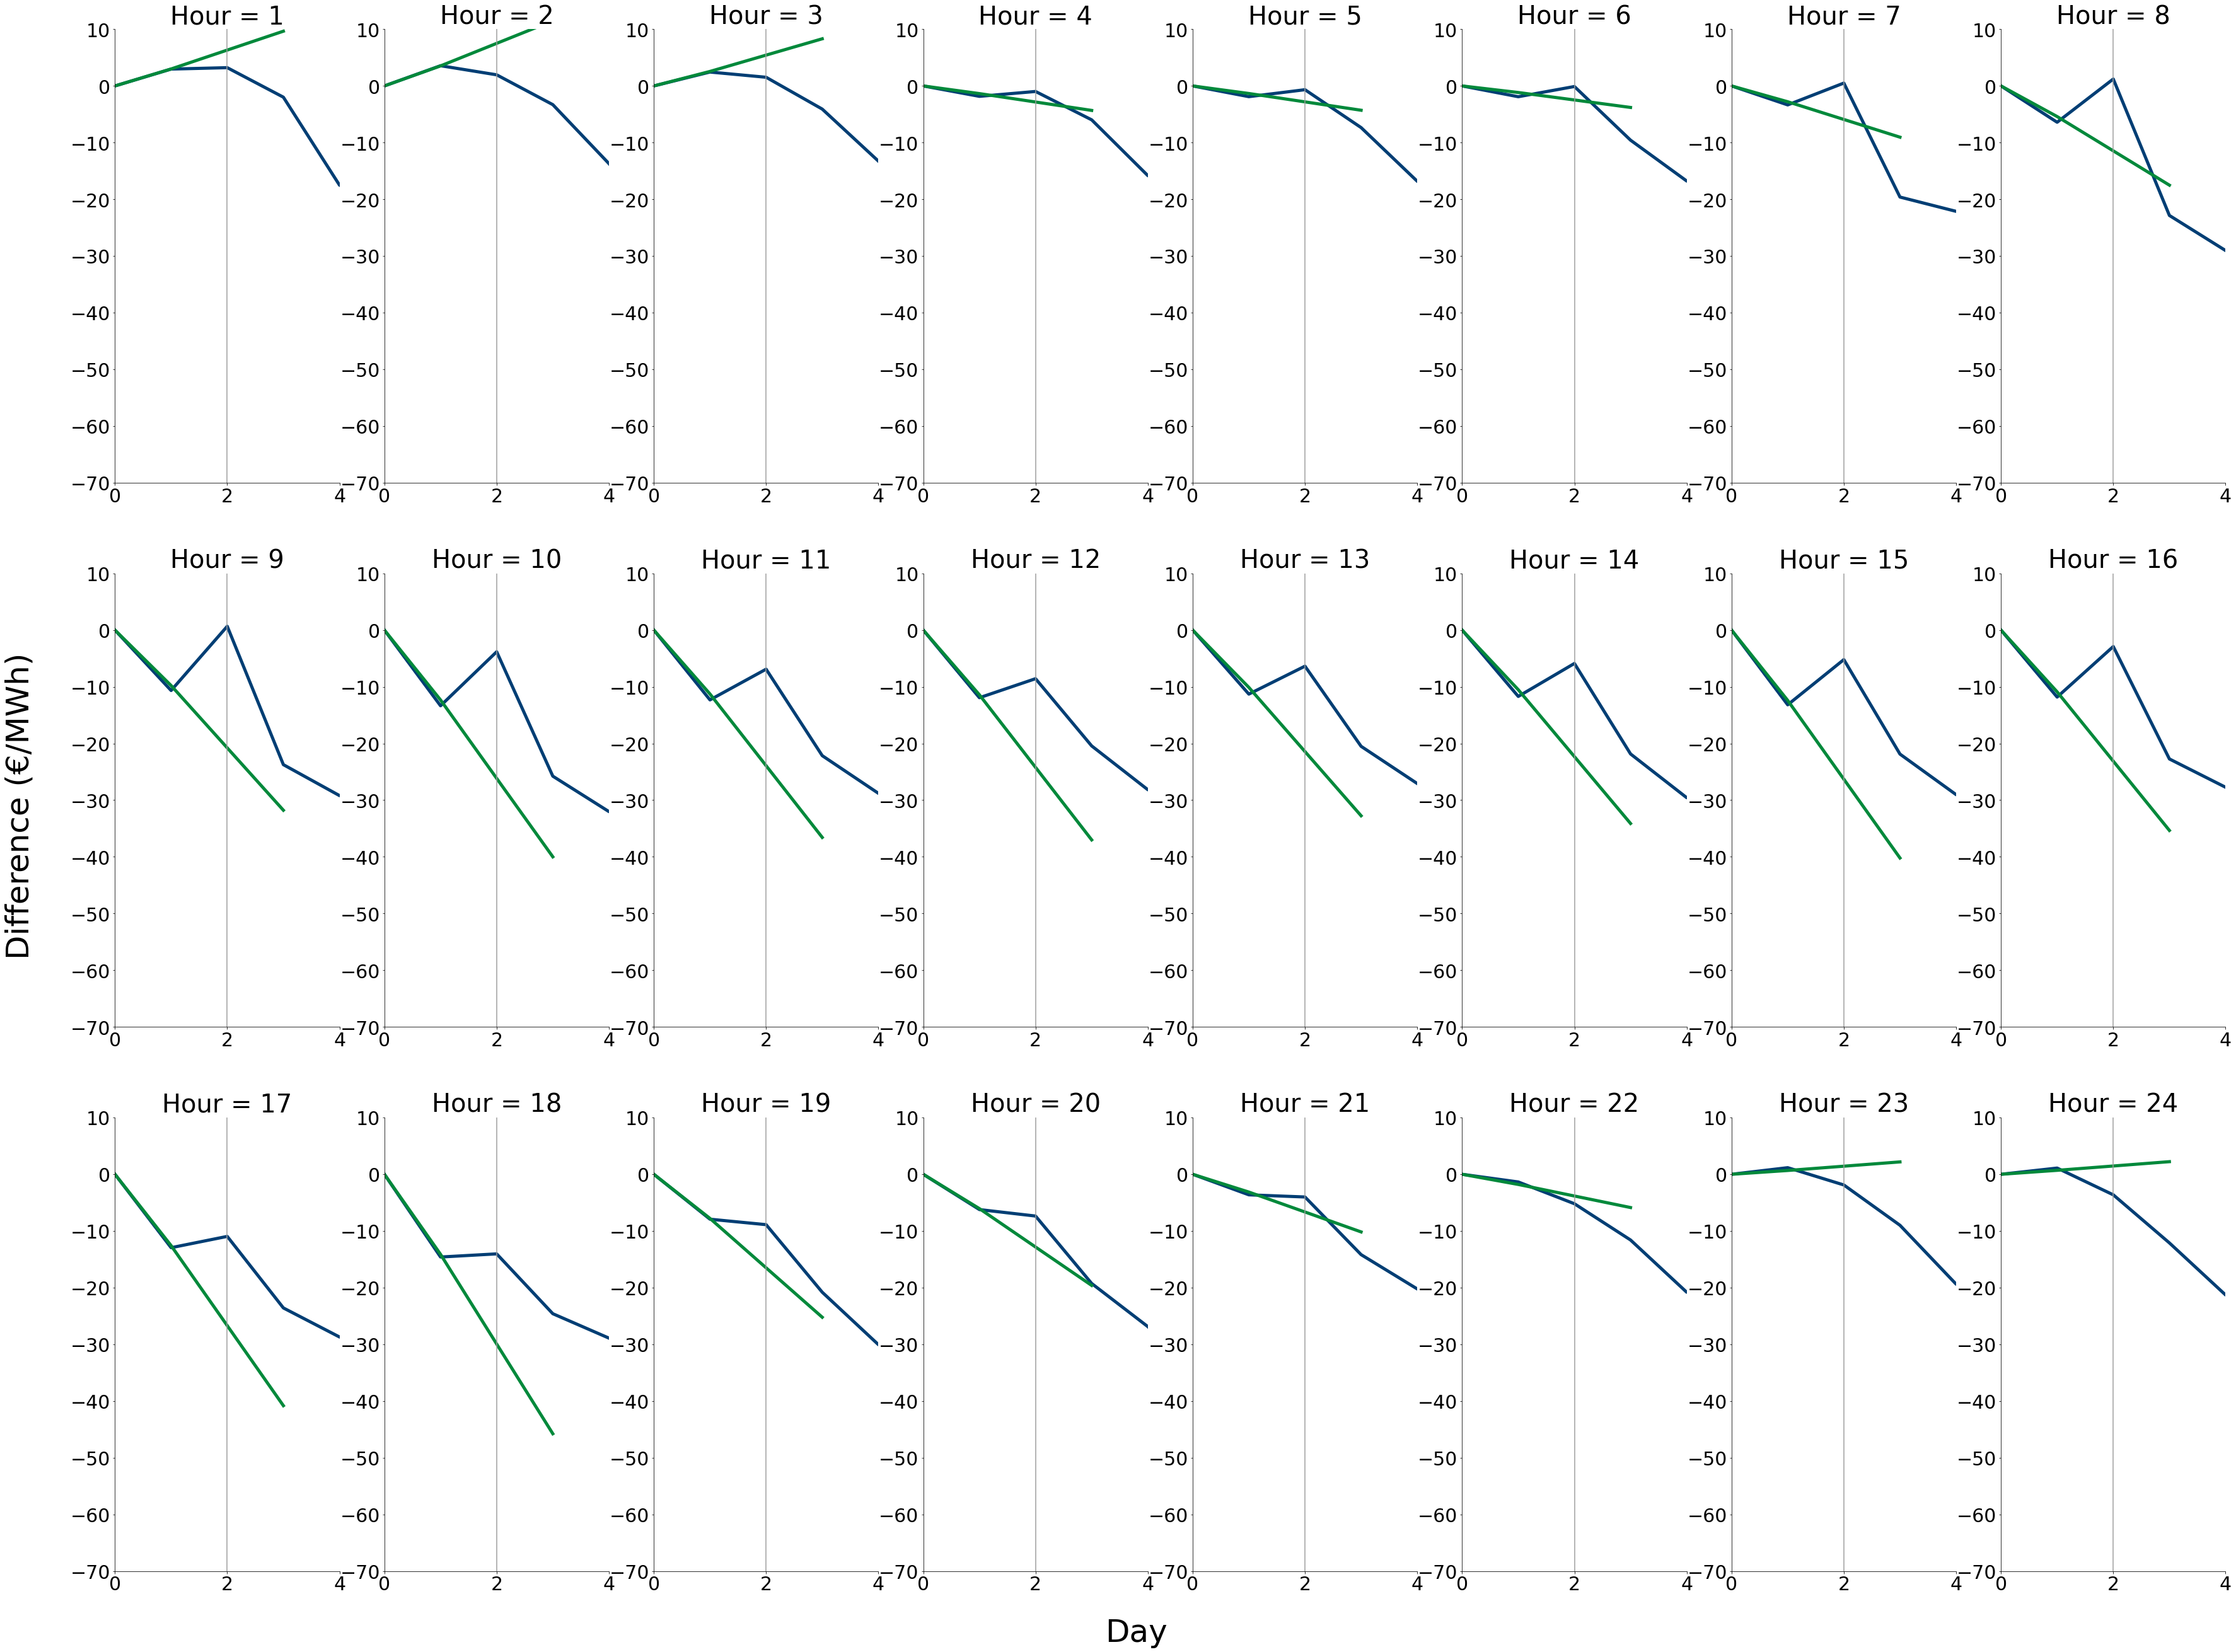

Mean absolute value error for test: 10.52


Training time step 2 - Iteration: 0250 | Total loss 6.210557 | Time: 2.49 mins
Training time step 2 - Iteration: 0500 | Total loss 6.195609 | Time: 2.75 mins
Training time step 2 - Iteration: 0750 | Total loss 6.068453 | Time: 3.03 mins
Training time step 2 - Iteration: 1000 | Total loss 6.035668 | Time: 3.31 mins


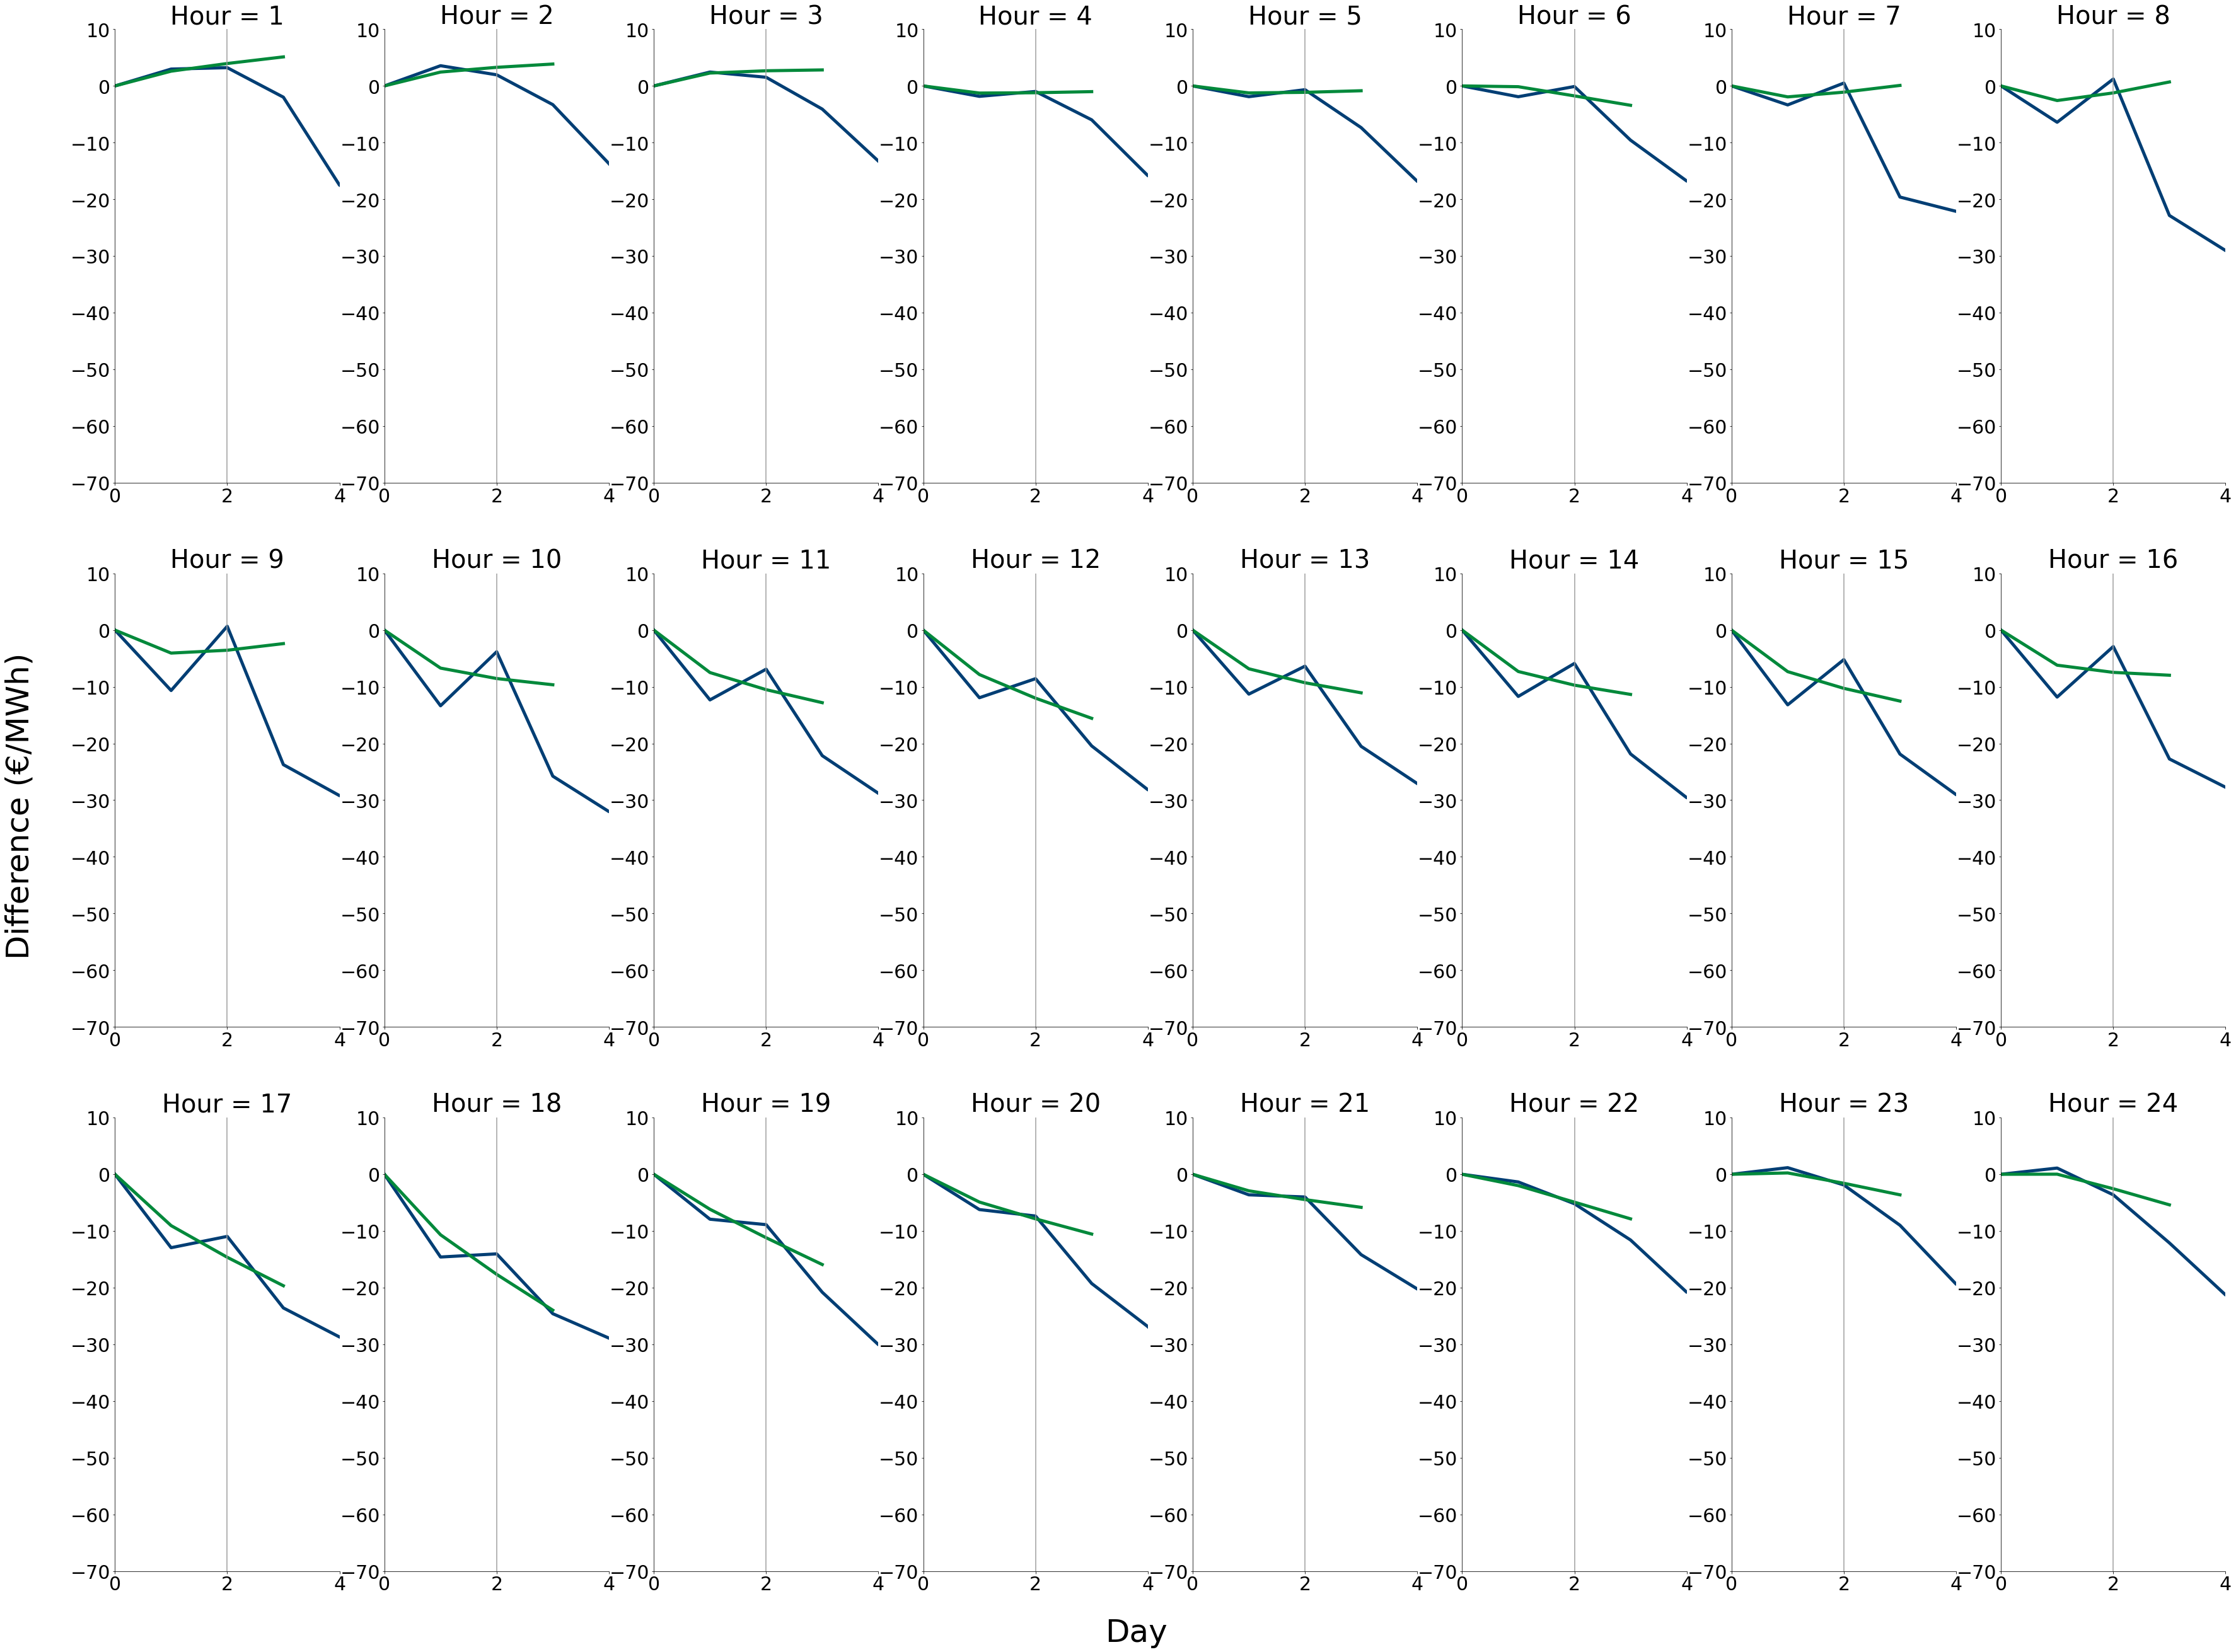

Mean absolute value error for test: 9.17


Training time step 2 - Iteration: 1250 | Total loss 5.971329 | Time: 3.64 mins
Training time step 2 - Iteration: 1500 | Total loss 5.947340 | Time: 3.96 mins
Training time step 2 - Iteration: 1750 | Total loss 5.934385 | Time: 4.30 mins
Training time step 2 - Iteration: 2000 | Total loss 5.926333 | Time: 4.65 mins


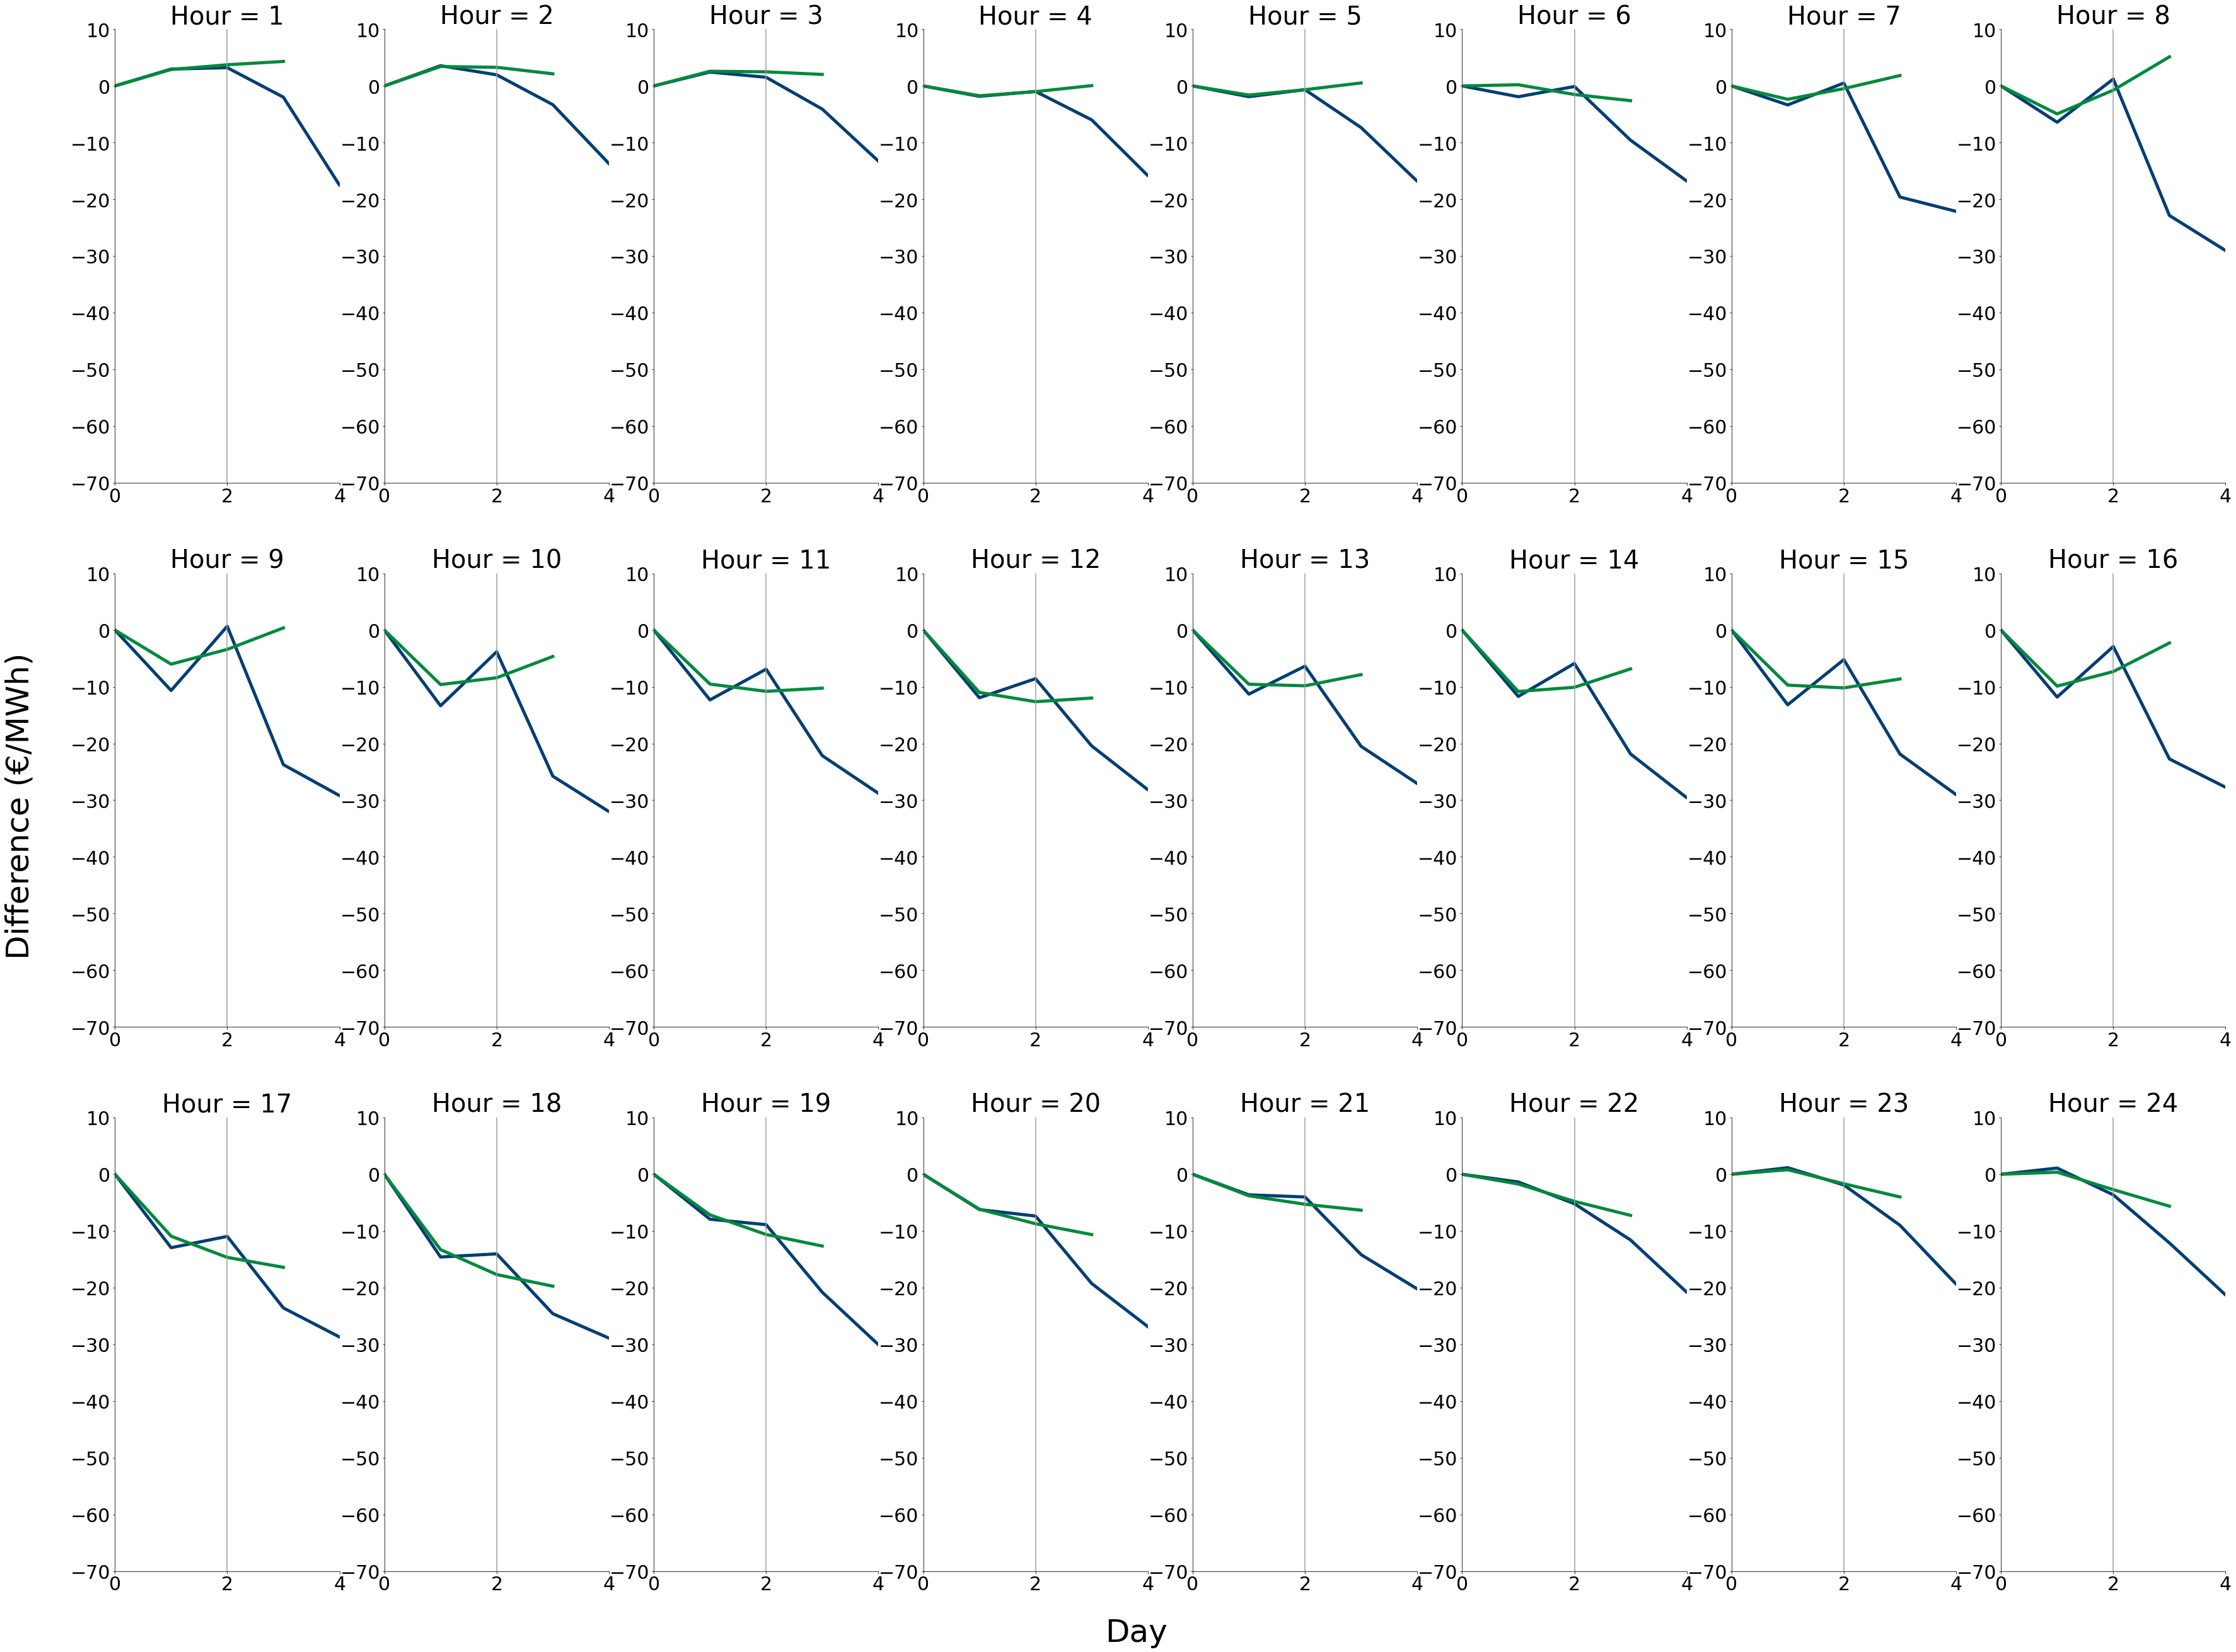

Mean absolute value error for test: 11.15


Training time step 3 - Iteration: 0000 | Total loss 8.234784 | Time: 4.68 mins


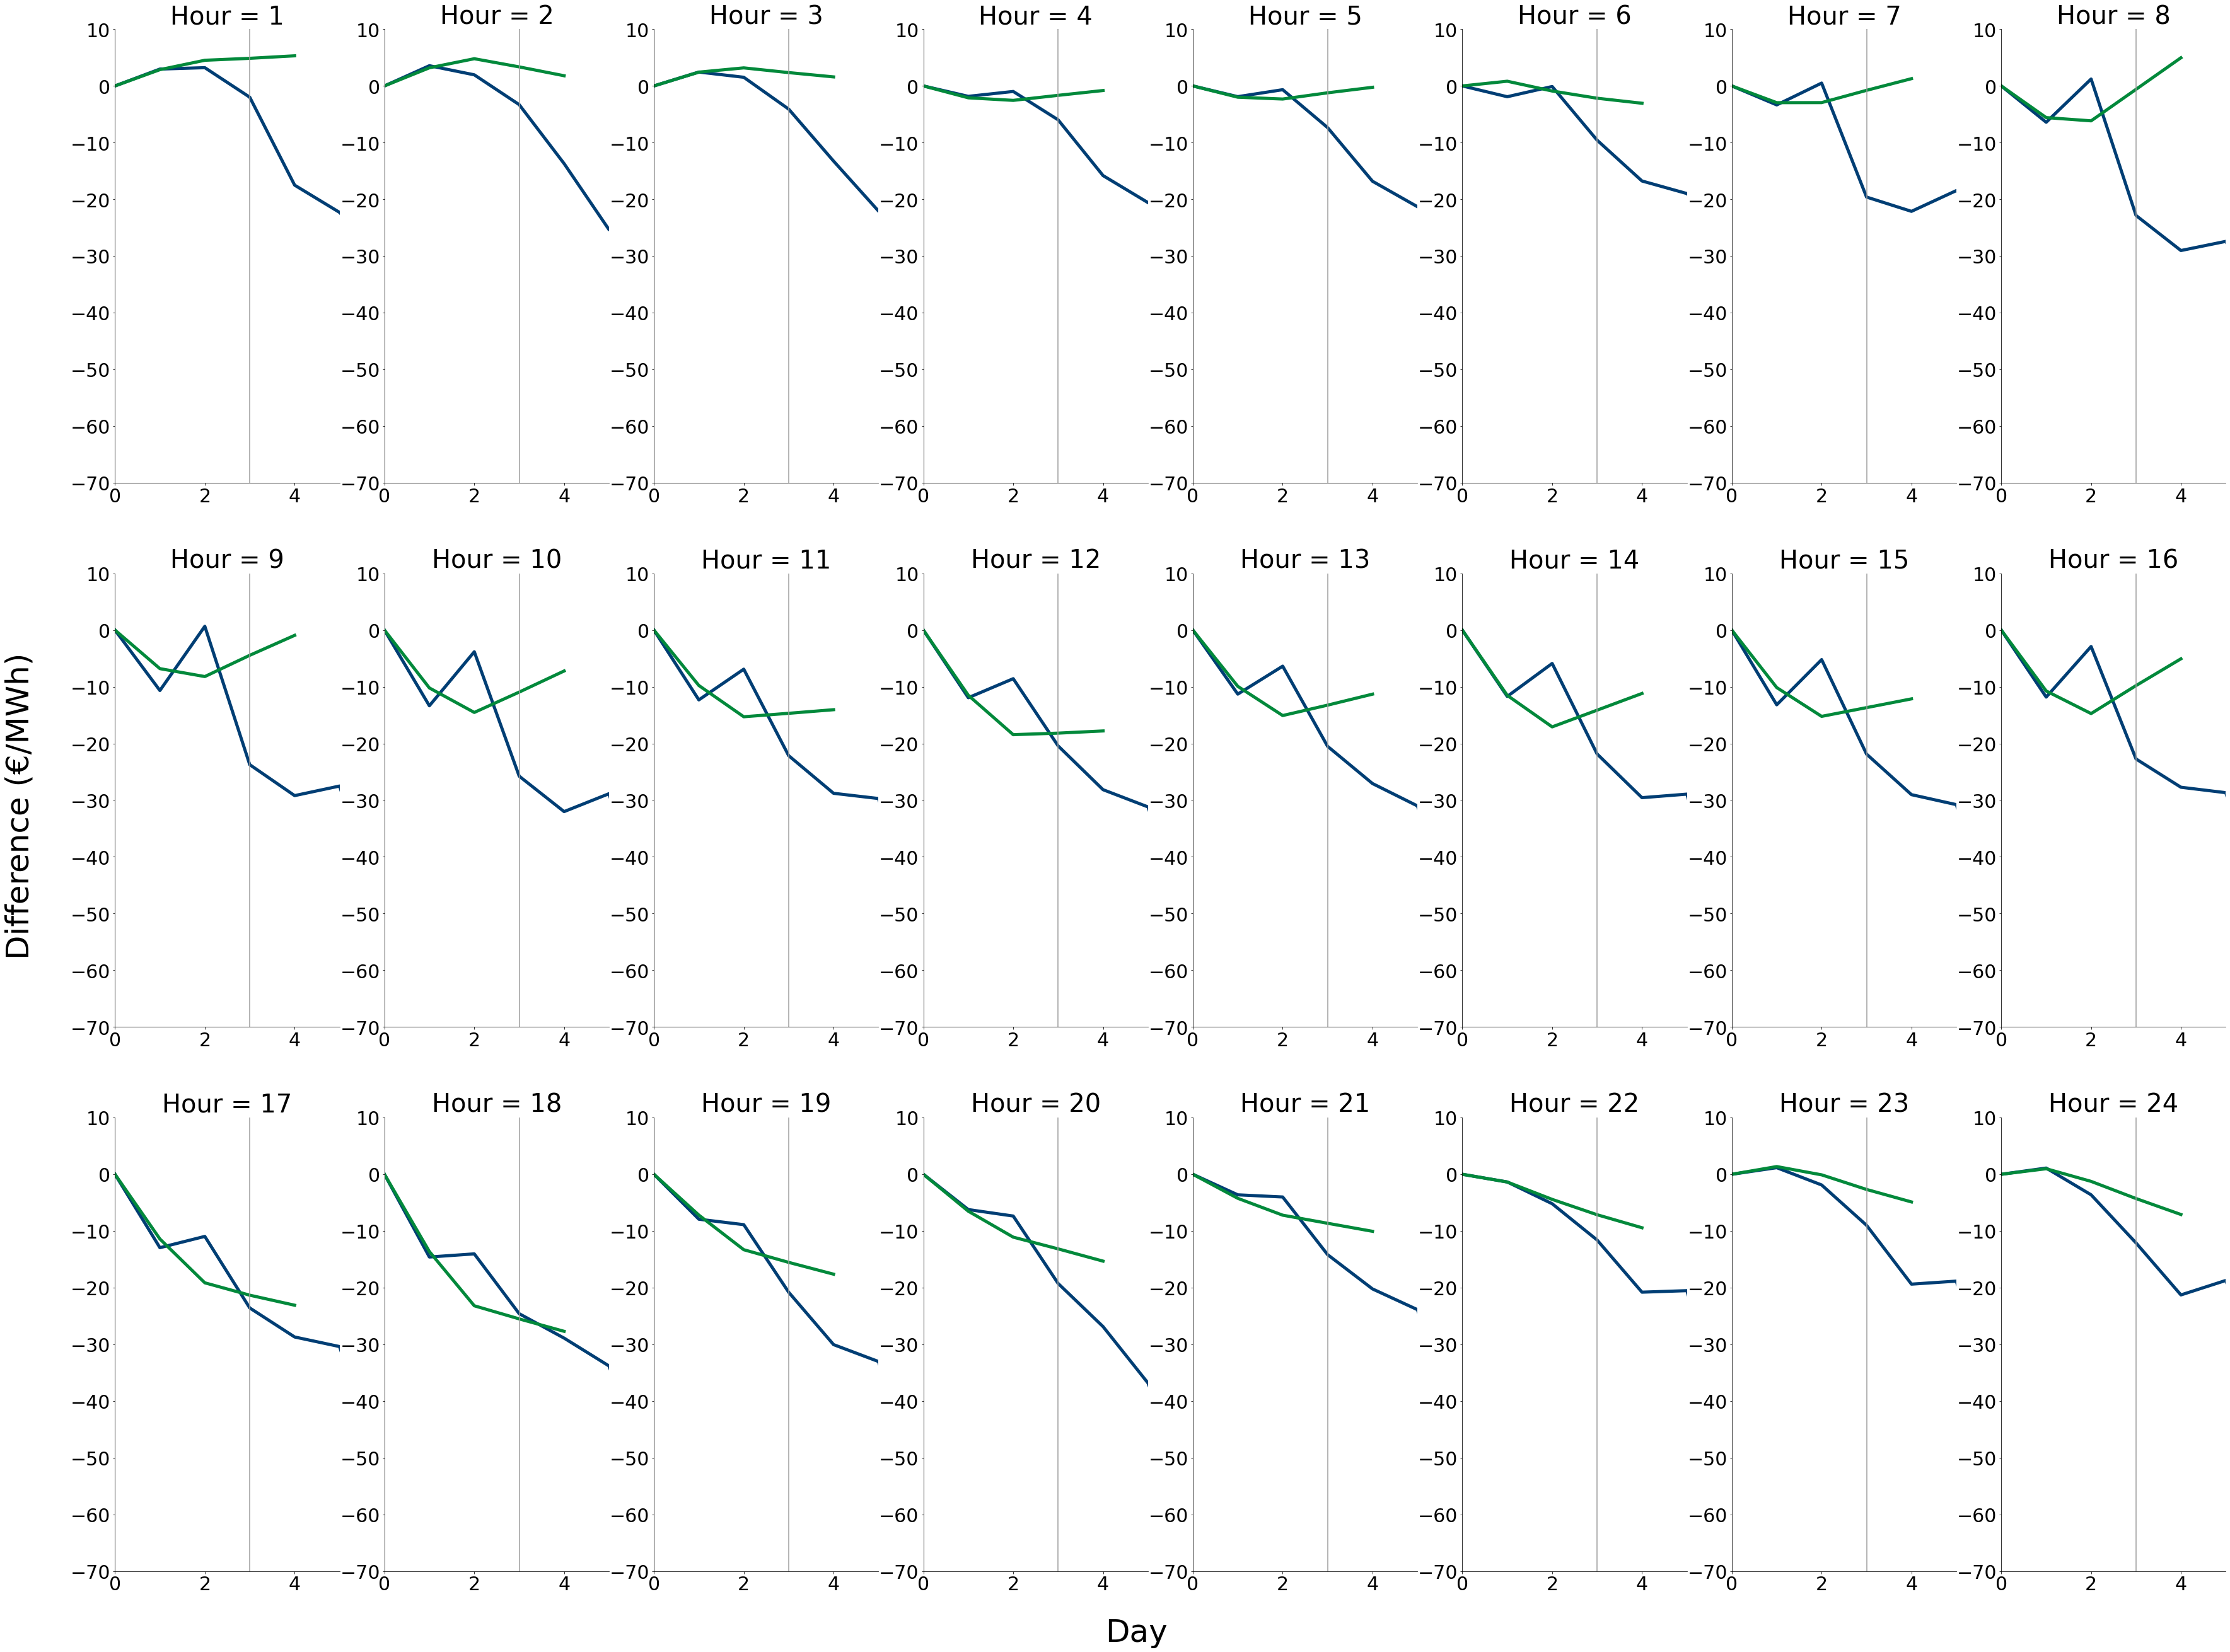

Mean absolute value error for test: 16.20


Training time step 3 - Iteration: 0250 | Total loss 7.502911 | Time: 5.08 mins
Training time step 3 - Iteration: 0500 | Total loss 7.415909 | Time: 5.48 mins
Training time step 3 - Iteration: 0750 | Total loss 7.305753 | Time: 5.89 mins
Training time step 3 - Iteration: 1000 | Total loss 7.345812 | Time: 6.32 mins


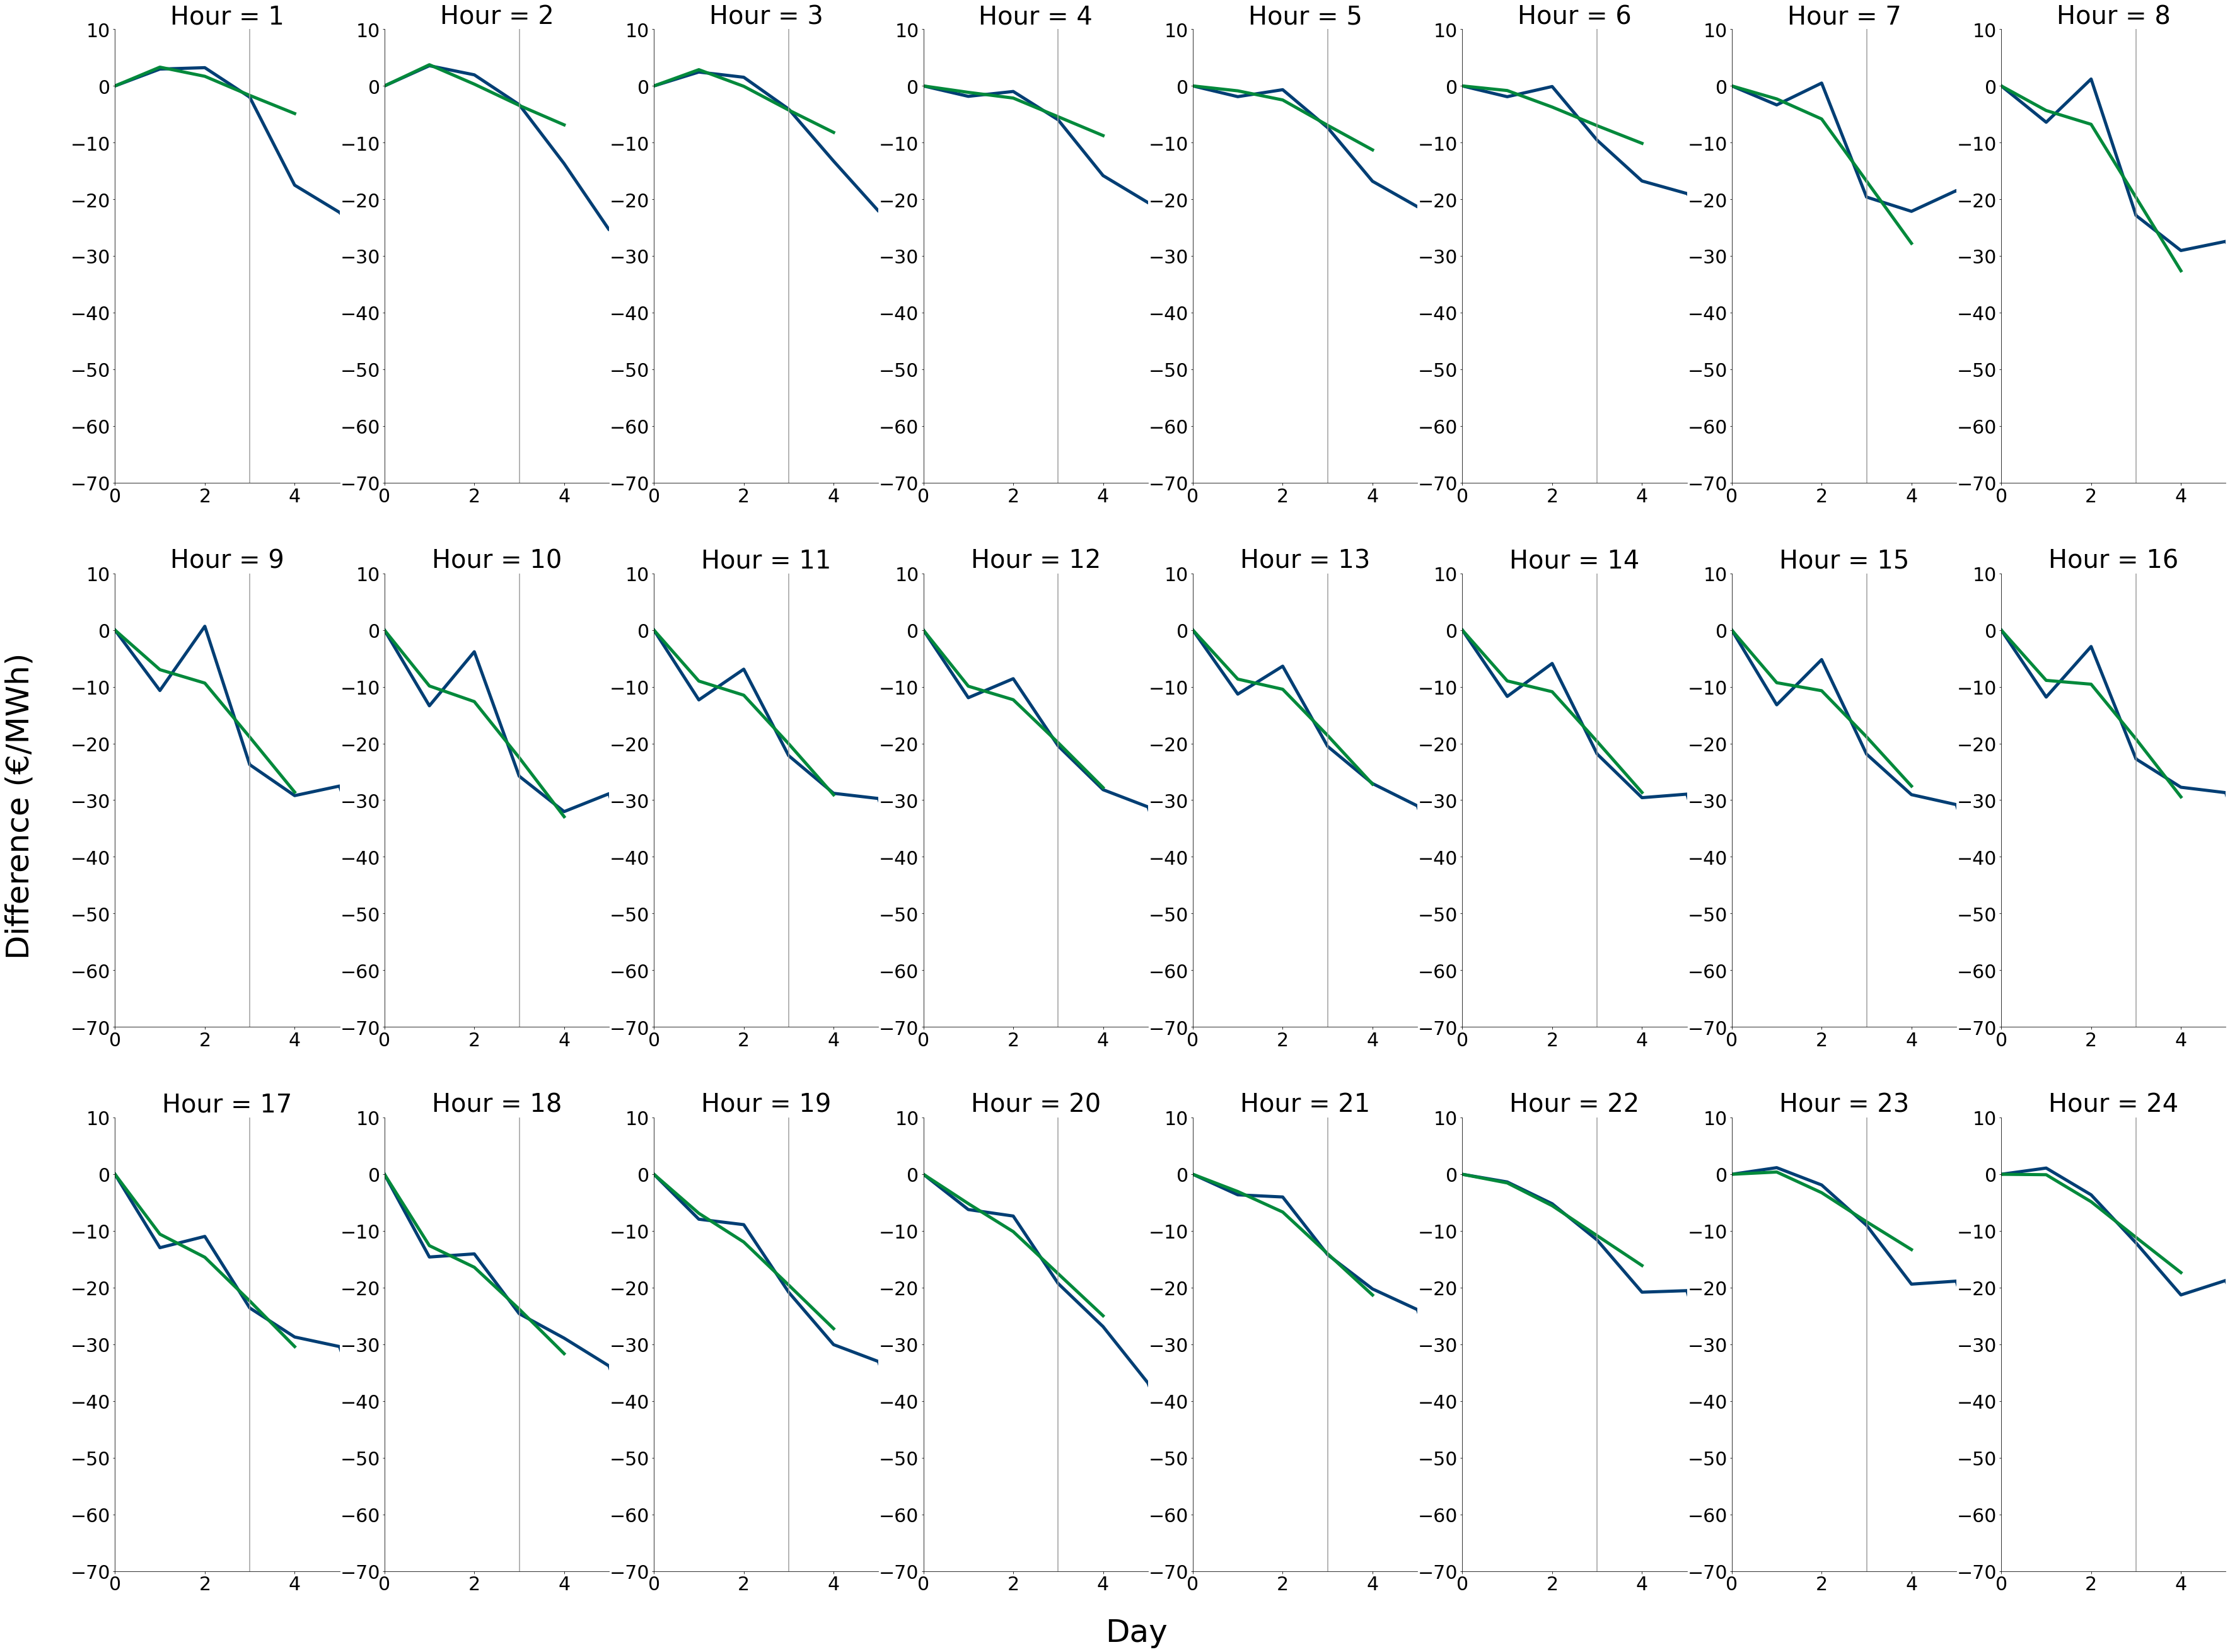

Mean absolute value error for test: 3.51


Training time step 3 - Iteration: 1250 | Total loss 7.237736 | Time: 6.83 mins
Training time step 3 - Iteration: 1500 | Total loss 7.252367 | Time: 7.32 mins
Training time step 3 - Iteration: 1750 | Total loss 7.156685 | Time: 7.84 mins
Training time step 3 - Iteration: 2000 | Total loss 7.277514 | Time: 8.37 mins


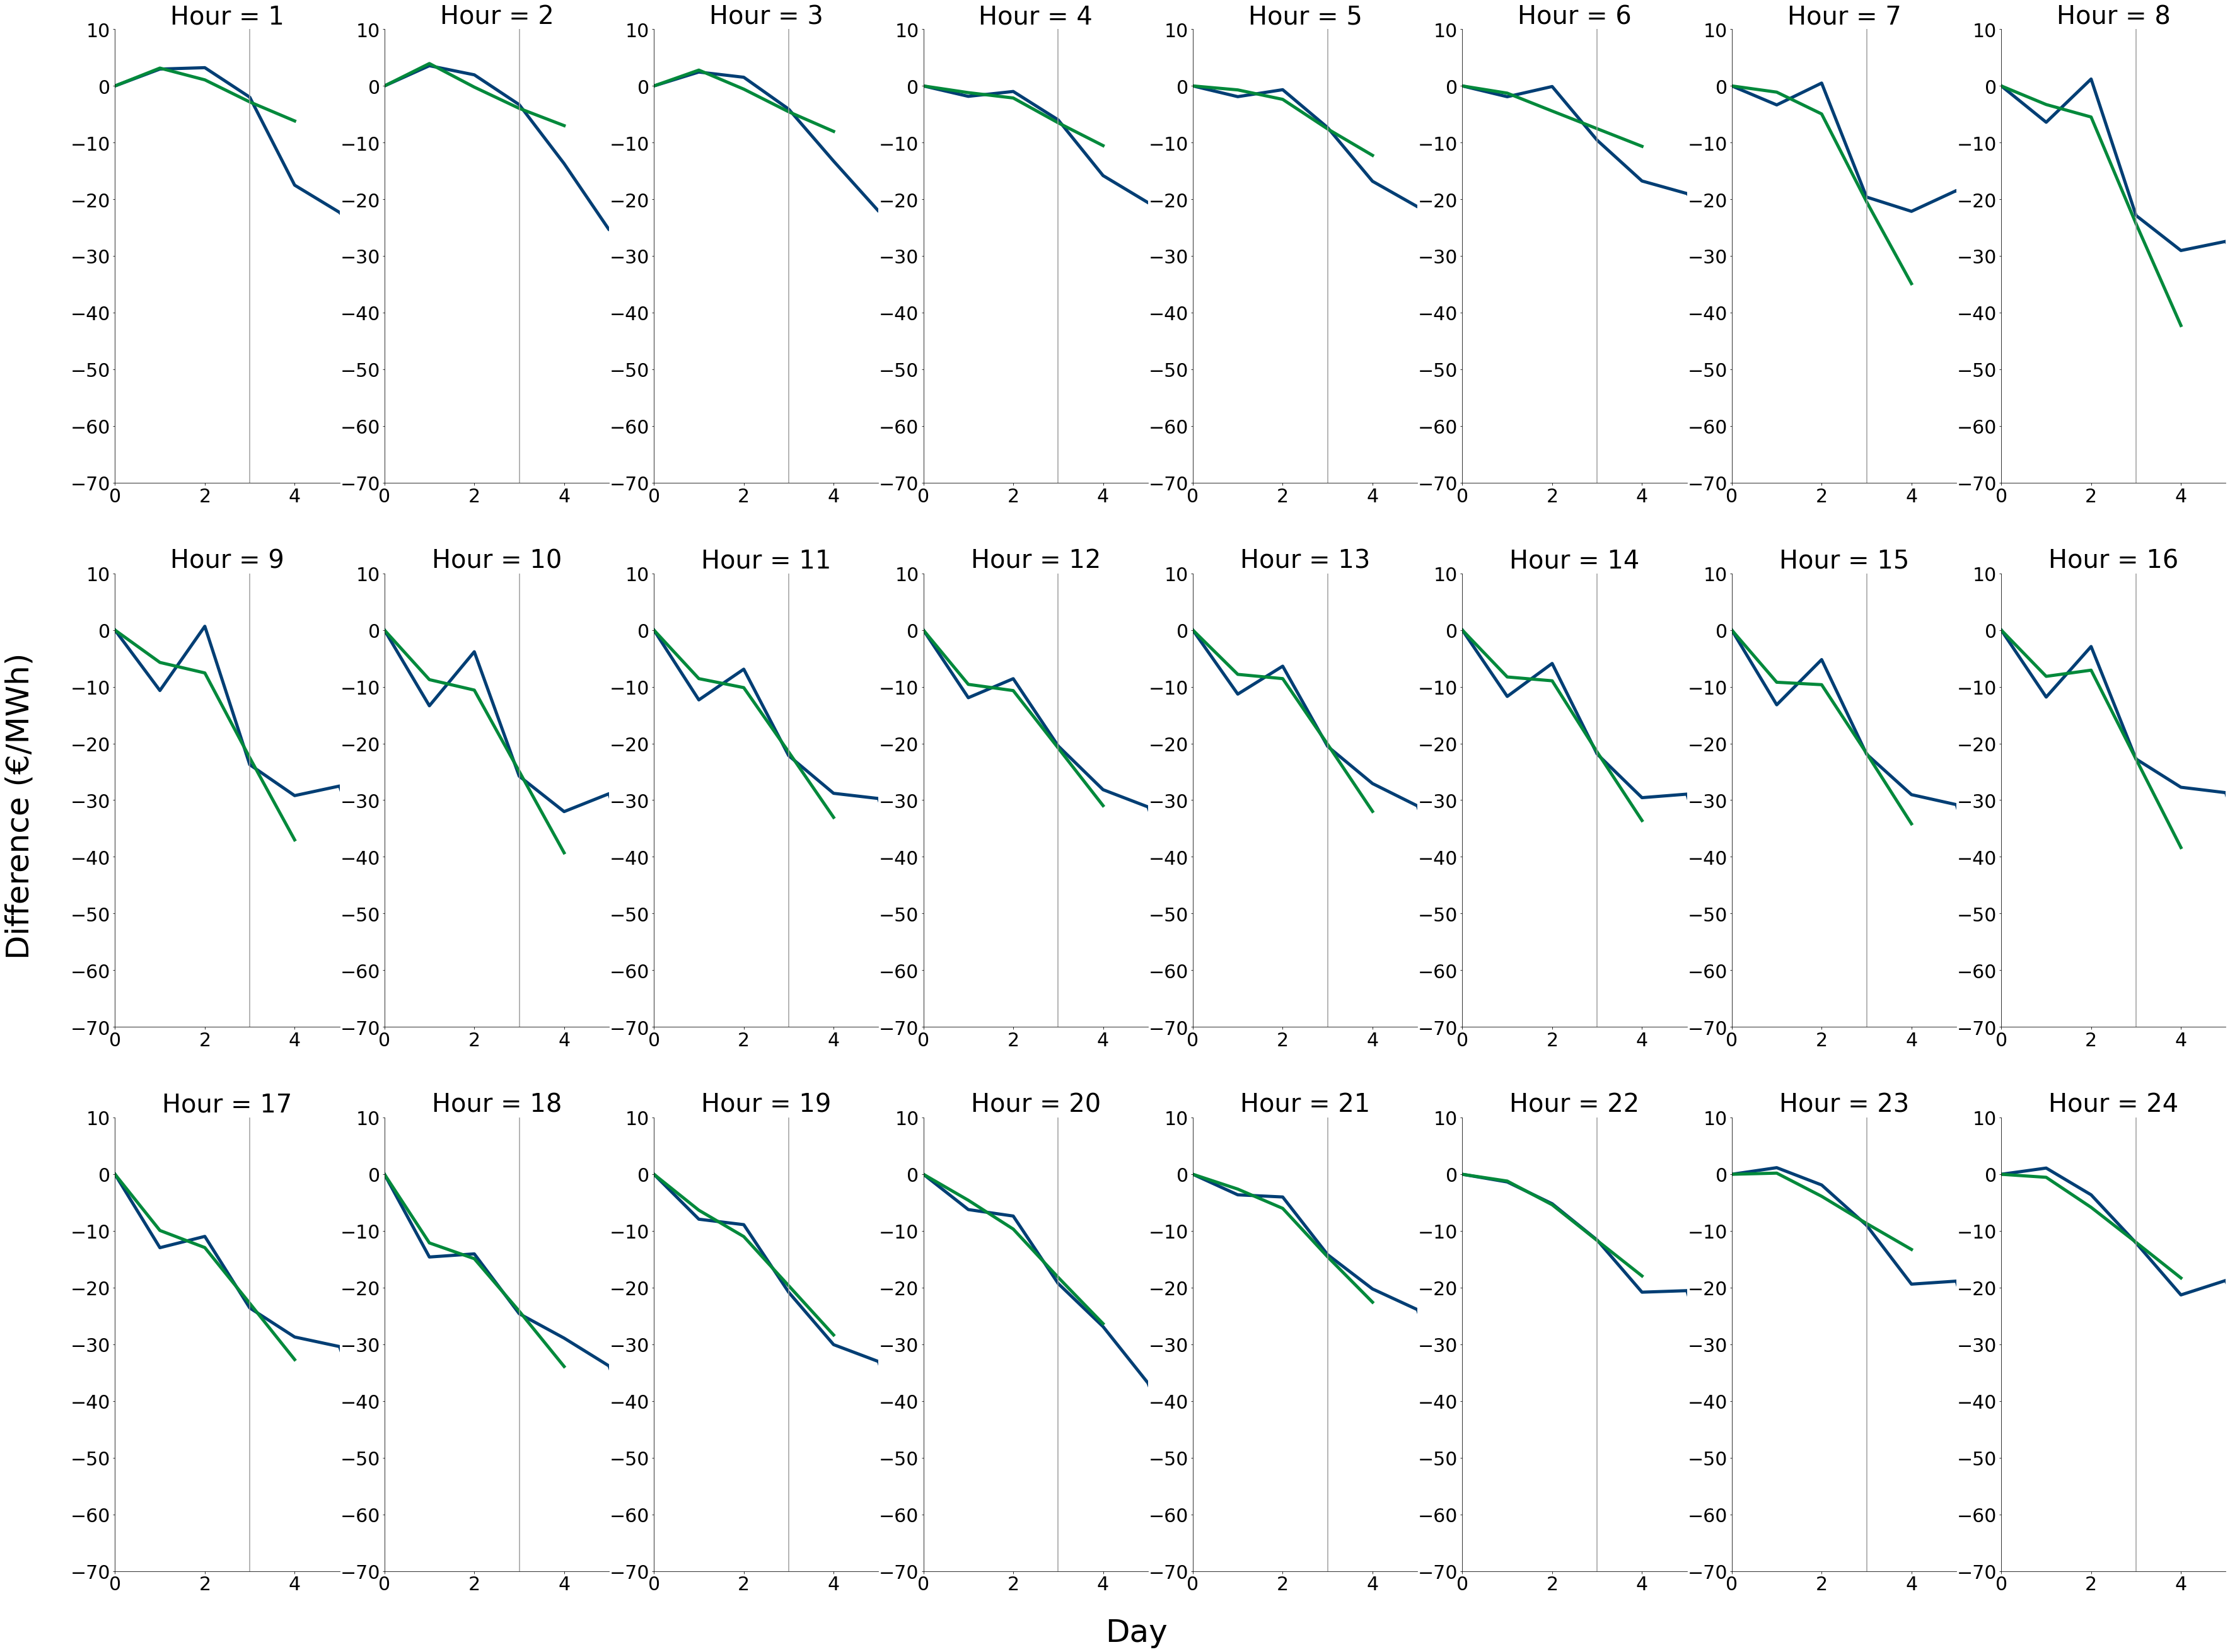

Mean absolute value error for test: 5.73


Training time step 4 - Iteration: 0000 | Total loss 8.184054 | Time: 8.41 mins


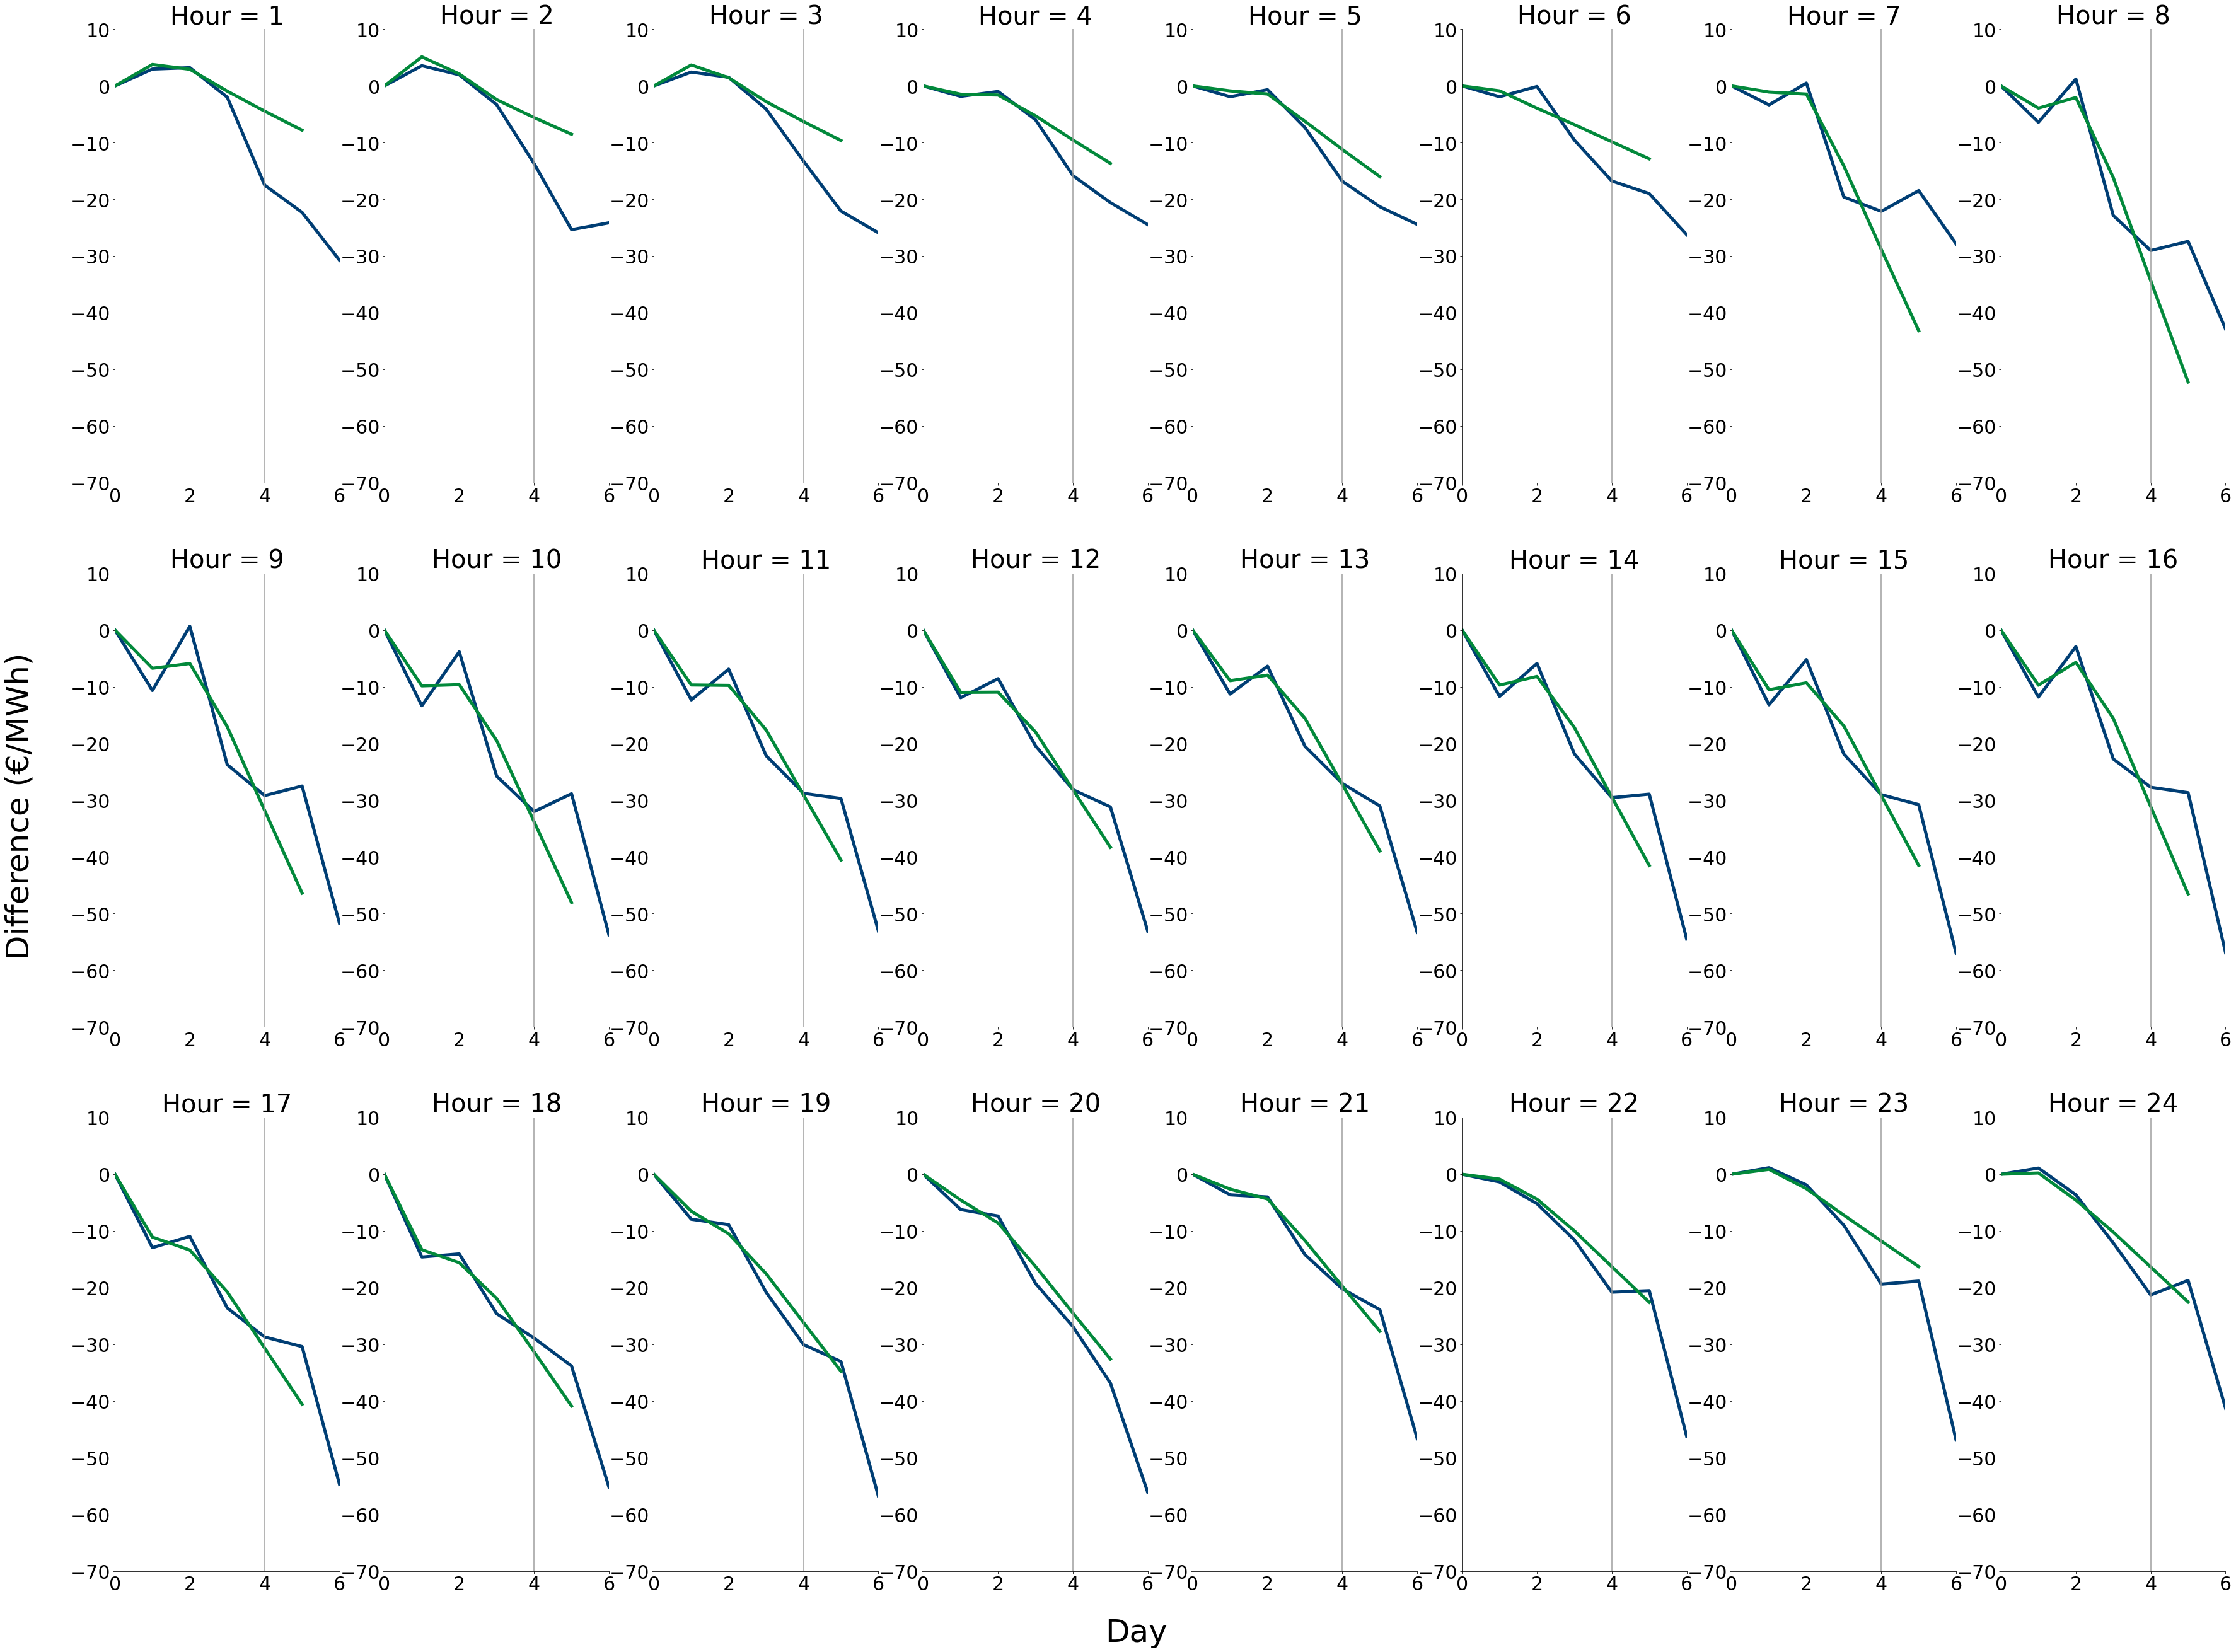

Mean absolute value error for test: 10.51


Training time step 4 - Iteration: 0250 | Total loss 8.097977 | Time: 9.05 mins
Training time step 4 - Iteration: 0500 | Total loss 8.087503 | Time: 9.65 mins
Training time step 4 - Iteration: 0750 | Total loss 8.183931 | Time: 10.24 mins
Training time step 4 - Iteration: 1000 | Total loss 8.136388 | Time: 10.84 mins


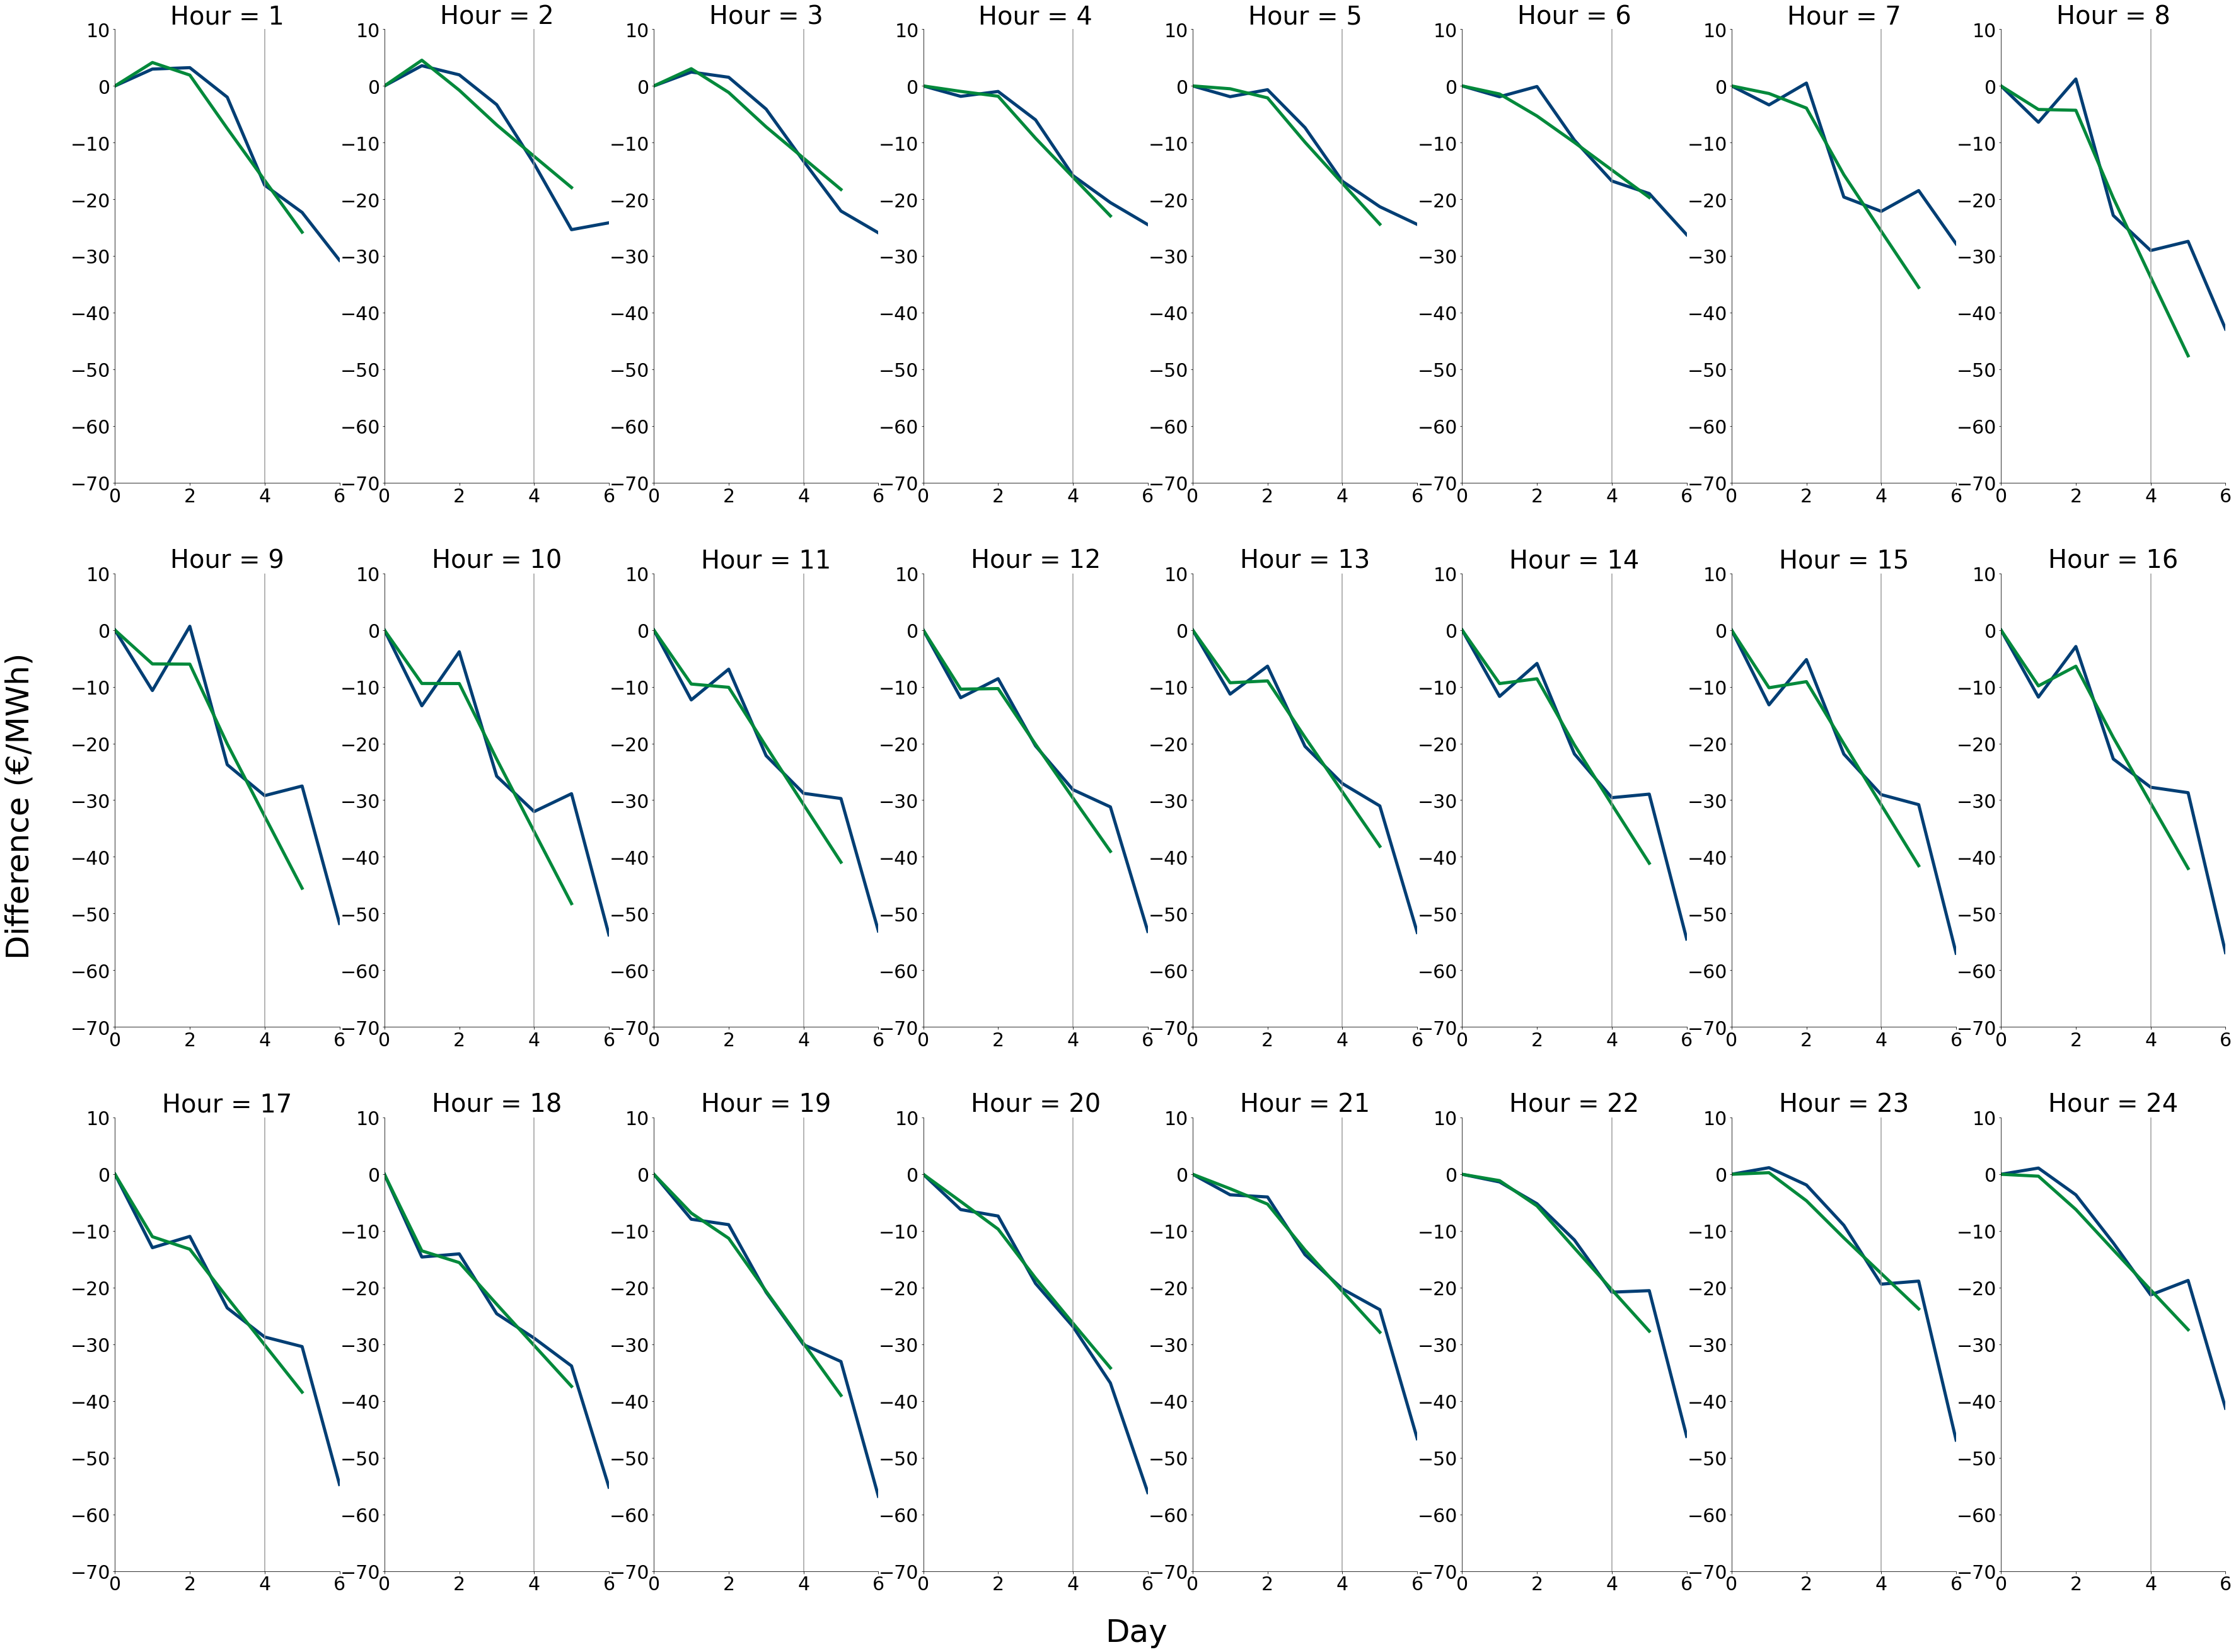

Mean absolute value error for test: 8.46


Training time step 4 - Iteration: 1250 | Total loss 8.130368 | Time: 11.52 mins
Training time step 4 - Iteration: 1500 | Total loss 8.061504 | Time: 12.14 mins
Training time step 4 - Iteration: 1750 | Total loss 8.118396 | Time: 12.77 mins
Training time step 4 - Iteration: 2000 | Total loss 8.068767 | Time: 13.45 mins


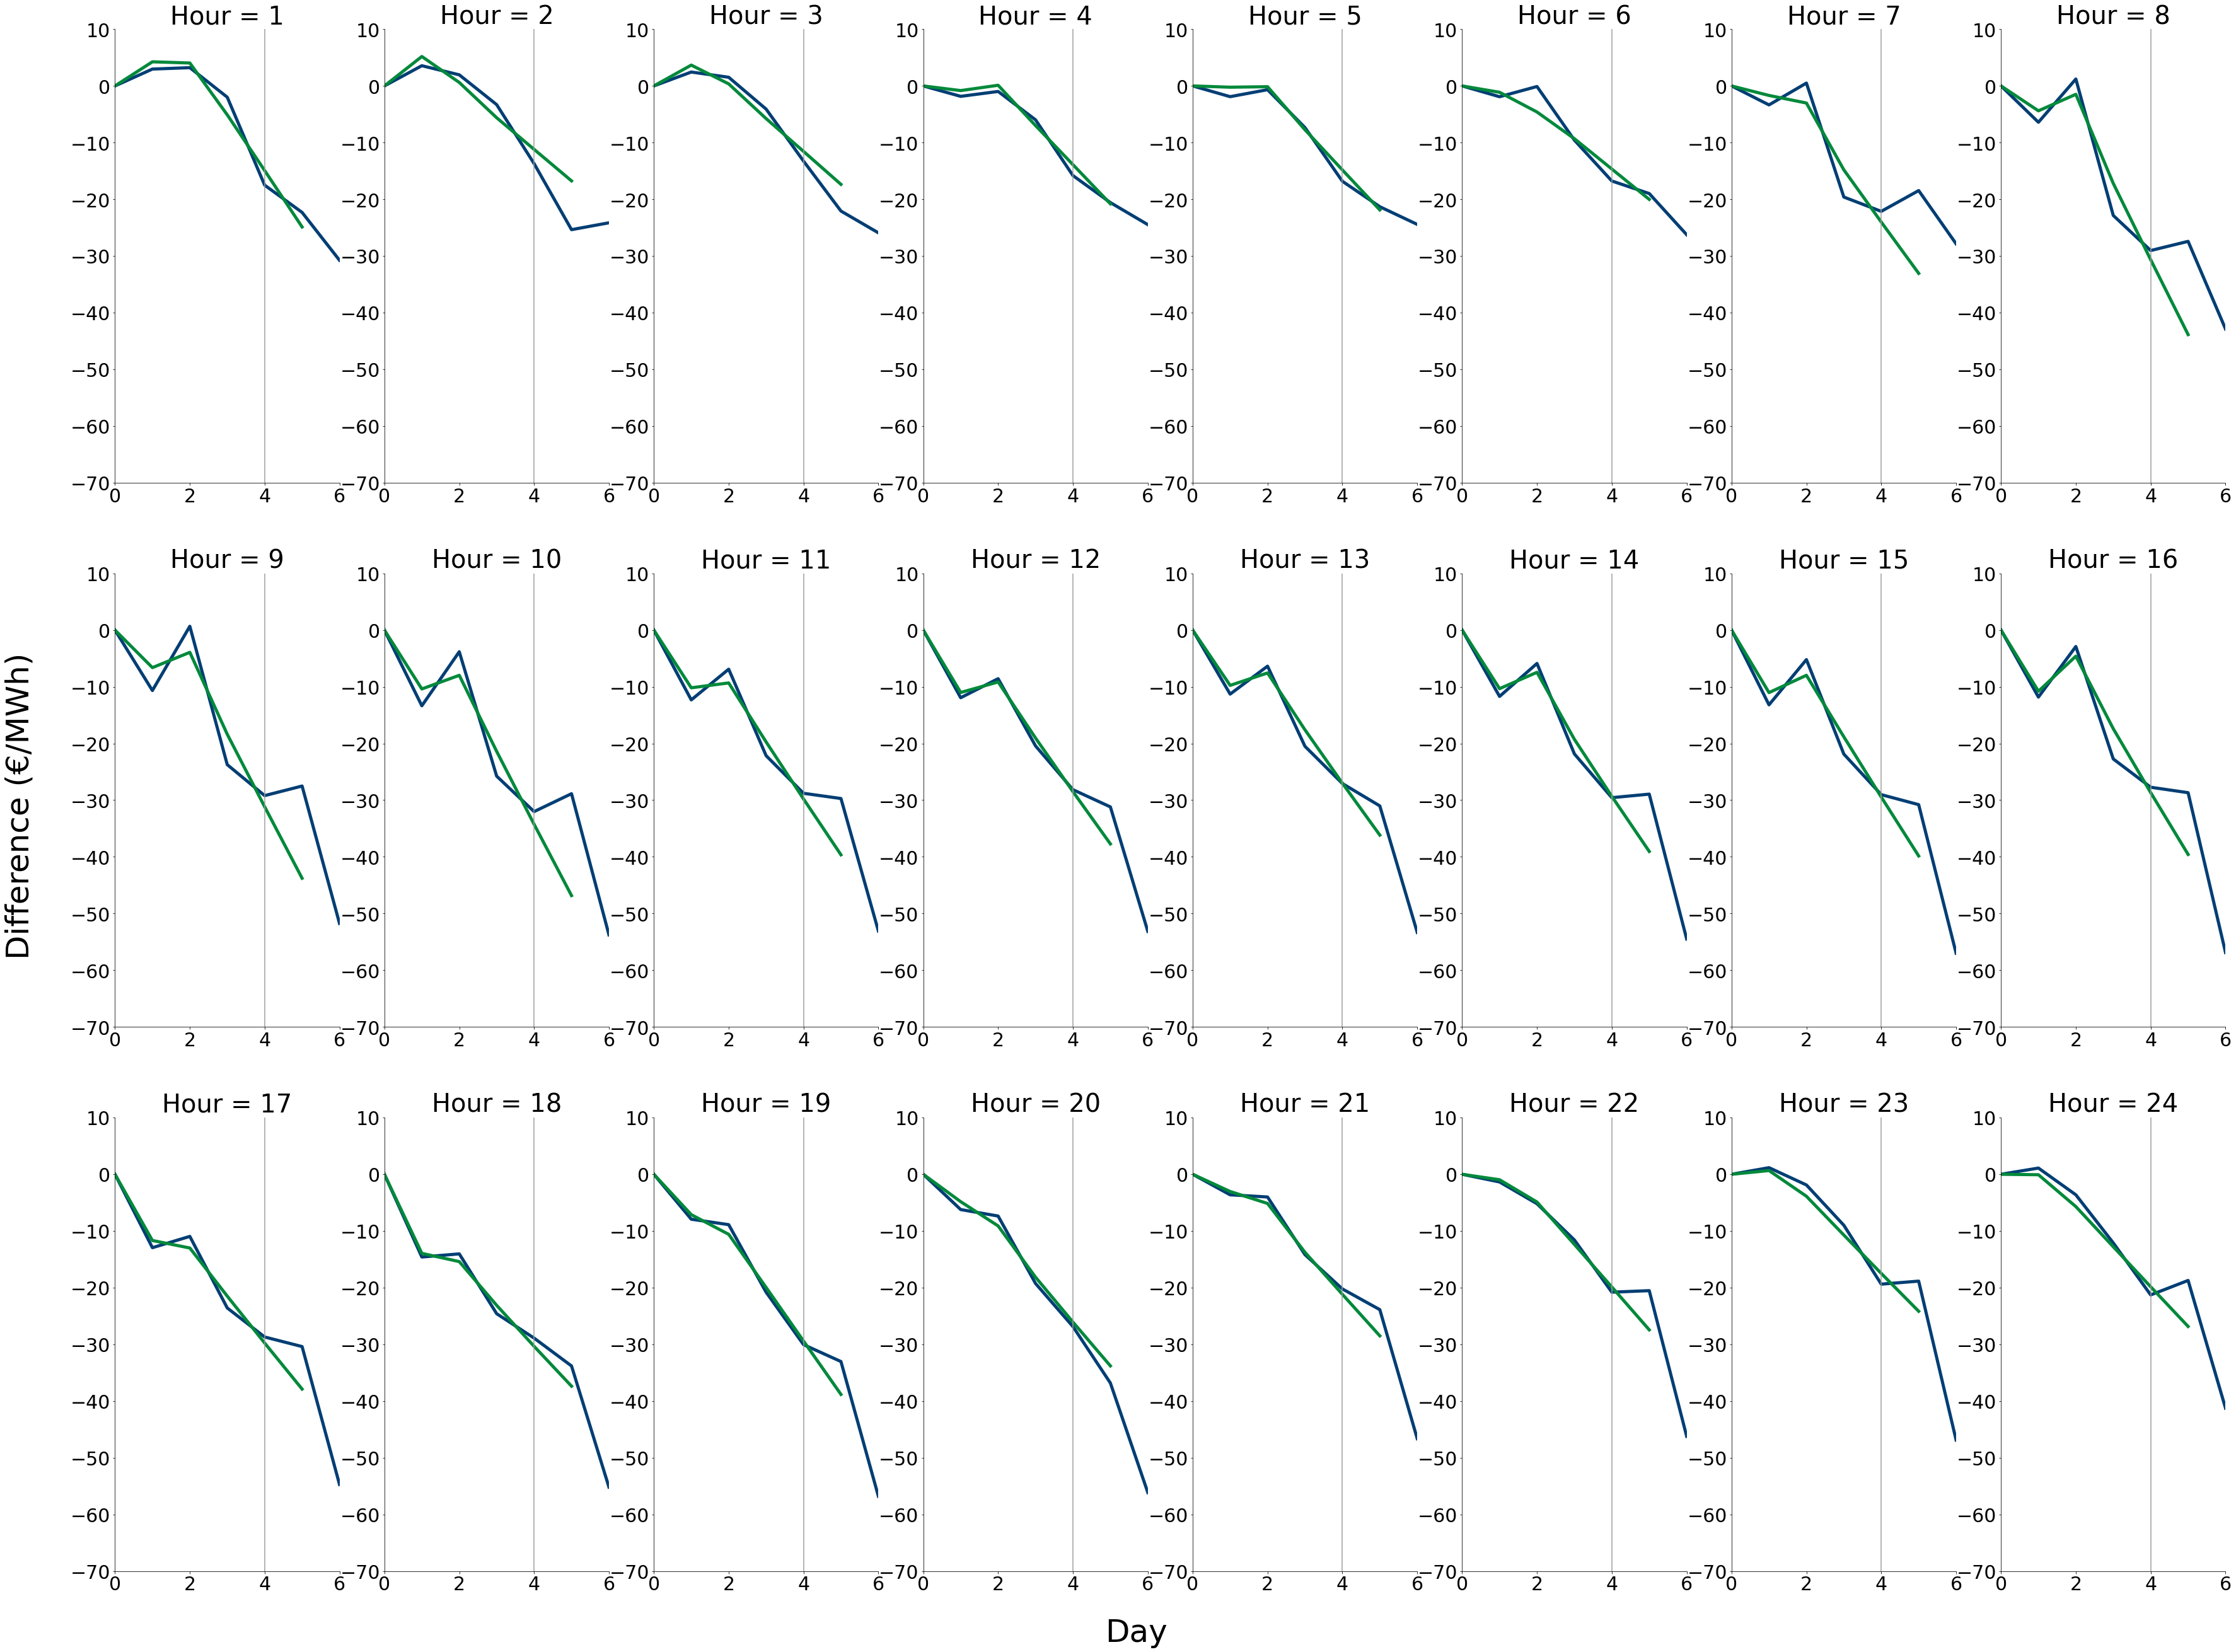

Mean absolute value error for test: 7.48




In [12]:
device = torch.device("cpu")

init_window_length = 0
time_step = 1

func = ODEfunc(obs_dim=24, hidden_layer_1=24*4).to(device)
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start = time.time()
for j in range(1, 5):
    training_ts = init_window_length + time_step*j

    loss_meter = RunningAverageMeter(0.97)
    
    for itr in range(0, 2_000+1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_multivariate_batch(train_df=hour_ts_diff_df, time_step=training_ts)
        batch_y0 = batch_y0.to(device)
        batch_t = batch_t.to(device)
        batch_y = batch_y.to(device)

        pred_y = odeint(func, batch_y0, batch_t).to(device)

        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item())
        end = time.time()
        training_time = (end-start) / 60

        if itr % 250 == 0:
            print(f"Training time step {j} - Iteration: {itr:04d} | Total loss {loss_meter.avg:.6f} | Time: {training_time:.2f} mins")
        
        if itr % 1_000 == 0:
            # evaluate training and test set
            true_y0 = get_mean_tensor_from_trajectories(traj_df=hour_ts_diff_df, time_step=0)
            batch_test_t = torch.from_numpy(np.arange(training_ts+2, dtype=np.float64))
            true_test_y = get_mean_tensor_from_trajectories(traj_df=hour_ts_diff_df, time_step=training_ts+1)
            with torch.no_grad():
                pred_test_y = odeint(func, true_y0, batch_test_t)
                plot_training_evaluation(pred_tensor=pred_test_y, train_df=hour_ts_diff_df, training_ts=training_ts)
                plt.show()
                test_loss = torch.mean(torch.abs(true_test_y - pred_test_y[-1]))
                print(f"Mean absolute value error for test: {test_loss:.2f}")
            
            print("\n" + "="*115 + "\n")